### **This notebook contains a custom callback you may wish to copy and use  
It is a combination of the Keras callbacks Reduce Learning Rate on Plateau,  
Early Stopping and Model Checkpoint but eliminates some of the limitations  
of each. In addition it provides an easier to read summary of the model's  
performance at the end of each epoch. It also provides a handy feature  
that enables you to set the number of epochs to train for until a message  
asks if you wish to halt training on the current epoch by entering H or  
to enter an integer which will determine how many more epochs to run  
before the message appears again. This is very useful if you are training  
a model and decide the metrics are satisfactory and you want to end  
the model training early. Note the callback always returns your model  
with the weights set to those of the epoch which had the highest performance  
on the metric being monitored (accuracy or validation accuracy)  
The callback initially monitors training accuracy and will adjust the learning  
rate based on that until the accuracy reaches a user specified threshold  
level. Once that level of training accuracy is achieved the callback switches  
to monitoring validation loss and adjusts the learning rate based on that.  
the callback is of the form:  
callbacks=[LRA(model, base_model, patience, stop_patience, threshold,factor, dwell,
              batches, initial_epoch, epochs, ask_epoch )]    
 **where:**
 - **model** is your compiled model  
 - **base_model** is the name of your base_model if you are doing transfer learning.  
      for example you might have in your model  
      base_model=tf.keras.applications.EfficientNetB1(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
      base_model.trainabel=False   During training you will be asked if you want to do fine tuning  
      If you enter F to the query, the base_model will be set to trainable by the callback
      If you are not doing transfer learning set base_model==None
 - **patience** is an integer that determines many consecutive epochs can occur before the learning rate
   will be adjusted (similar to patience parameter in Reduce Learning Rate on Plateau)
 
 - **stop_patience** is an integer that determines hom many consecutive epochs for which the
   learning rate was adjusted but no improvement in the monitored metric occurred before
   training is halted(similar to patience parameter in early stopping)
 
 - **threshold** is a float that determines the level that training accuracy must achieve
   before the callback switches over to monitoring validation loss. This  is useful for
   cases where the validation loss in early epochs tends to vary widely and can cause
   unwanted behavior when using the conventional Keras callbacks
 - **factor** is a float that determines the new learning rate by the equation lr=lr*factor.
   (similar to the factor parameter in Reduce Learning Rate on Plateau)
 - **dwell** is a boolean. It is used in the callback as part of an experiment on training
   models. If on a given epoch the metric being monitored fails to improve it means
   your model has moved to a location on the surface of Nspace (where N is the number
   of trainable parameters) that is NOT as favorable (poorer metric performance) than
   the position in Nspace you were in for the previous epoch. If dwell is set to True
   the callback loads the model with the weights from the previous (better metric value)
   epoch. Why move to a worse place if the place you were in previously was better. Then
   the learning rate is reduced for the next epoch of training. If dwell is set to false
   this action does not take place.
 - **batches** is an integer. It should be set to a value of 
   batches=int(number of traing samples/batch_size). During training the callback provides
   information during an epoch of the form
   'processing batch of batches  accuracy= accuracy  loss= loss where batch is the current 
    batch being processs, batches is as described above, accuracy is the current training
    accuracy and loss is the current loss. Typically the message would appear as
    processing batch 25 of 50  accuracy: 54%  loss: .04567. As each batch is processed
    these values are changed.    
 - **initial_epoch** is an integer. Typically set this to zero Itis used in the information
    printed out for each epoch. In the case where you train the model say with the
    basemodel weights frozen say you train for 10 epochs. Then you want to fine tune
    the model and train for more eppochs for the second training session you would
    reinstantiate the callback and set initial_epoch=10.
 - **epochs** an integer value for the number of epochs to train
 - **ask_epoch** is either set to an integer value or None. If set to an integer it denotes
    the epoch number at which user input is requested. If the user enter H training is
    halted. If the user inters an integer it represents how many more epochs to run
    before you are asked for the user input again. If the user enters F the base_model
    is made trainable If ask_epoch is set to None the
    user is NOT asked to provide any input. This feature is handy is when training your model
    and the metrics are either unsatisfactory and you want to stop training, or for the case
    where your metrics are satisfactory and there is no need to train any further. Note
    you model is always set to the weights for the epoch that had the beset metric
    performance. So if you halt the training you can still use the model for predictions.  
      
### ** Example of Use:
 callbacks=[LRA(model=my_model, base_model=base_model, patience=1,stop_patience=3,  
            threshold=.9, factor=.5, dwell=True,batches=85, initial_epoch=0 , epochs=20, ask_epoch=5)]
 this implies:
 - your model is my_model
 - base_model is the name of your base_model if you are doing transfer learning
 - after 1 epoch of no improvement the learning rate will be reduced
 - after 3 consecutive adjustment of the leaarning rate with no metric improve training terminates
 - once the training accuracy reaches 90% the callback adjust learning rate based on validation loss
 - when the learning rate is adjust the new learning rate is .5 X learning rate
 - if the current epoch's metric value did not improve, the weights for the prior epoch are loaded
   and the learning rate is reduced
 - 85 batches of data are run to complete an epoch 
 - the initial epoch is 0
 - train for 20 epochs
 - after the fifth epoch you will be asked if you want to halt training by entering H or enter 
   an integer denoting how many more epochs to run before you will be prompted again or enter
   F to make the base_model=trainable

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML
# stop annoying tensorflow warning messages
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import scipy.io
from glob import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import Input, layers
from keras.layers import *
from keras.models import *
from keras.optimizers import *

In [ ]:
#Import the dataset and read the image into a seperate variable
# Please update the path accordingly where are the images
from google.colab import drive
drive.mount('/content/MyDrive')
images='./MyDrive/MyDrive/archive/image'

#all_imgs = images.glob(images + '/*.jpeg',recursive=True)
#print("The total images present in the dataset: {}".format(len(all_imgs)))

Mounted at /content/MyDrive


### Define a function to show example training images

In [ ]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()

In [ ]:
def show_images(tdir):
    classlist=os.listdir(tdir)
    length=len(classlist)
    columns=5
    rows=int(np.ceil(length/columns))    
    plt.figure(figsize=(20, rows * 4))
    for i, klass in enumerate(classlist):    
        classpath=os.path.join(tdir, klass)
        imgpath=os.path.join(classpath, '1.jpg')
        img=plt.imread(imgpath)
        plt.subplot(rows, columns, i+1)
        plt.axis('off')
        plt.title(klass, color='blue', fontsize=12)
        plt.imshow(img)
    

### Define  a function to print text in RGB foreground and background colors

In [ ]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

### Define a subclass of Keras callbacks that will control the learning rate and print
### training data in spreadsheet format. The callback also includes a feature to
### periodically ask if you want to train for N more epochs or halt

In [ ]:
class LRA(keras.callbacks.Callback):
    def __init__(self,model, base_model, patience,stop_patience, threshold, factor, dwell, batches, initial_epoch,epochs, ask_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.base_model=base_model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.batches=batches # number of training batch to runn per epoch
        self.initial_epoch=initial_epoch
        self.epochs=epochs
        self.ask_epoch=ask_epoch
        self.ask_epoch_initial=ask_epoch # save this value to restore if restarting training
        # callback variables 
        self.count=0 # how many times lr has been reduced without improvement
        self.stop_count=0        
        self.best_epoch=1   # epoch with the lowest loss        
        self.initial_lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it         
        self.highest_tracc=0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss=np.inf # set lowest validation loss to infinity initially
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights=self.model.get_weights()   # save initial weights if they have to get restored 
        
    def on_train_begin(self, logs=None):        
        if self.base_model != None:
            status=base_model.trainable
            if status:
                msg=' initializing callback starting train with base_model trainable'
            else:
                msg='initializing callback starting training with base_model not trainable'
        else:
            msg='initialing callback and starting training'                        
        print_in_color (msg, (244, 252, 3), (55,65,80)) 
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print_in_color(msg, (244,252,3), (55,65,80)) 
        self.start_time= time.time()
        
    def on_train_end(self, logs=None):
        stop_time=time.time()
        tr_duration= stop_time- self.start_time            
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        msg=f'Training is completed - model is set with weights from epoch {self.best_epoch} '
        print_in_color(msg, (0,255,0), (55,65,80))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color(msg, (0,255,0), (55,65,80))   
        
    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100  # get training accuracy 
        loss=logs.get('loss')
        msg='{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='') # prints over on the same line to show running batch count        
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now 
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy 
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')    
        color= (0,255,0)    
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if epoch ==0:
                pimprov=0.0
            else:
                pimprov= (acc-self.highest_tracc )*100/self.highest_tracc
            if acc>self.highest_tracc: # training accuracy improved in the epoch                
                self.highest_tracc=acc # set new highest training accuracy
                self.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.best_epoch=epoch + 1  # set the value of best epoch for this epoch              
            else: 
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1: # lr should be adjusted
                    color=(245, 170, 66)
                    lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count=0 # reset counter
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space                        
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1 # increment patience counter                    
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if epoch ==0:
                pimprov=0.0
            else:
                pimprov= (self.lowest_vloss- v_loss )*100/self.lowest_vloss
            if v_loss< self.lowest_vloss: # check if the validation loss improved 
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                self.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved  
                self.stop_count=0  
                color=(0,255,0)                
                self.best_epoch=epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count>=self.patience-1: # need to adjust lr
                    color=(245, 170, 66)
                    lr=lr * self.factor # adjust the learning rate                    
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted 
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space
                else: 
                    self.count =self.count +1 # increment the patience counter                    
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,255), (55,65,80))
            self.model.stop_training = True # stop training
        else: 
            if self.ask_epoch !=None:
                if epoch + 1 >= self.ask_epoch:
                    if base_model.trainable:
                        msg='enter H to halt  or an integer for number of epochs to run then ask again'
                    else:
                        msg='enter H to halt ,F to fine tune model, or an integer for number of epochs to run then ask again'
                    print_in_color(msg, (0,255,255), (55,65,80))
                    ans=input('')
                    if ans=='H' or ans=='h':
                        msg=f'training has been halted at epoch {epoch + 1} due to user input'
                        print_in_color(msg, (0,255,255), (55,65,80))
                        self.model.stop_training = True # stop training
                    elif ans == 'F' or ans=='f':
                        if base_model.trainable:
                            msg='base_model is already set as trainable'
                        else:
                            msg='setting base_model as trainable for fine tuning of model'
                            self.base_model.trainable=True
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80))                         
                        self.count=0
                        self.stop_count=0                        
                        self.ask_epoch = epoch + 1 + self.ask_epoch_initial 
                        
                    else:
                        ans=int(ans)
                        self.ask_epoch +=ans
                        msg=f' training will continue until epoch ' + str(self.ask_epoch)                         
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80)) 

### Define a function to plot the training data

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()


### define a function to create confusion matrix and classification report

In [ ]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names     
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)         
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)
    tp = 0
    fp = 0
    fn = 0
    for index,cls in enumerate(classes):
      for index1 in range(len(y_true)):
        if y_true[index1] == index:
          if y_true[index1] == y_pred[index1]:
            tp += 1
          else:
            fn +=1
        elif y_pred[index1] == index:
          fp +=1
    precision = tp /(tp +fp)
    recall = tp /(tp +fn)
    f1_score = 2*precision * recall/(precision + recall)
    print('Over all F1 Score : ',f1_score)

In [ ]:
classes

['bumper_dent',
 'bumper_scratch',
 'door_dent',
 'door_scratch',
 'glass_shatter',
 'head_lamp',
 'tail_lamp',
 'unknown']

### define a function to save the model and the associated class_dict.csv file

In [ ]:
def saver(save_path, model, model_name, subject, accuracy,img_size, scalar, generator):
    # first save the model
    save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
    model_save_loc=os.path.join(save_path, save_id)
    model.save(model_save_loc)
    print_in_color ('model was saved as ' + model_save_loc, (0,255,0),(55,65,80)) 
    # now create the class_df and convert to csv file    
    class_dict=generator.class_indices 
    height=[]
    width=[]
    scale=[]
    for i in range(len(class_dict)):
        height.append(img_size[0])
        width.append(img_size[1])
        scale.append(scalar)
    Index_series=pd.Series(list(class_dict.values()), name='class_index')
    Class_series=pd.Series(list(class_dict.keys()), name='class') 
    Height_series=pd.Series(height, name='height')
    Width_series=pd.Series(width, name='width')
    Scale_series=pd.Series(scale, name='scale by')
    class_df=pd.concat([Index_series, Class_series, Height_series, Width_series, Scale_series], axis=1)    
    csv_name='class_dict.csv'
    csv_save_loc=os.path.join(save_path, csv_name)
    class_df.to_csv(csv_save_loc, index=False) 
    print_in_color ('class csv file was saved as ' + csv_save_loc, (0,255,0),(55,65,80))
    return model_save_loc, csv_save_loc

### define a function that uses the trained model and the
### class_dict.csv file to predict images

In [ ]:
def predictor(sdir, csv_path,  model_path, averaged=True, verbose=True):    
    # read in the csv file
    class_df=pd.read_csv(csv_path)    
    class_count=len(class_df['class'].unique())
    img_height=int(class_df['height'].iloc[0])
    img_width =int(class_df['width'].iloc[0])
    img_size=(img_width, img_height)    
    scale=class_df['scale by'].iloc[0] 
    image_list=[]
    # determine value to scale image pixels by
    try: 
        s=int(scale)
        s2=1
        s1=0
    except:
        split=scale.split('-')
        s1=float(split[1])
        s2=float(split[0].split('*')[1])
    path_list=[]
    paths=os.listdir(sdir)    
    for f in paths:
        path_list.append(os.path.join(sdir,f))
    if verbose:
        print (' Model is being loaded- this will take about 10 seconds')
    model=load_model(model_path)
    image_count=len(path_list) 
    image_list=[]
    file_list=[]
    good_image_count=0
    for i in range (image_count):        
        try:
            img=cv2.imread(path_list[i])
            img=cv2.resize(img, img_size)
            img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)            
            good_image_count +=1
            img=img*s2 - s1             
            image_list.append(img)
            file_name=os.path.split(path_list[i])[1]
            file_list.append(file_name)
        except:
            if verbose:
                print ( path_list[i], ' is an invalid image file')
    if good_image_count==1: # if only a single image need to expand dimensions
        averaged=True
    image_array=np.array(image_list)    
    # make predictions on images, sum the probabilities of each class then find class index with
    # highest probability
    preds=model.predict(image_array)    
    if averaged:
        psum=[]
        for i in range (class_count): # create all 0 values list
            psum.append(0)    
        for p in preds: # iterate over all predictions
            for i in range (class_count):
                psum[i]=psum[i] + p[i]  # sum the probabilities   
        index=np.argmax(psum) # find the class index with the highest probability sum        
        klass=class_df['class'].iloc[index] # get the class name that corresponds to the index
        prob=psum[index]/good_image_count  # get the probability average         
        # to show the correct image run predict again and select first image that has same index
        for img in image_array:  #iterate through the images    
            test_img=np.expand_dims(img, axis=0) # since it is a single image expand dimensions 
            test_index=np.argmax(model.predict(test_img)) # for this image find the class index with highest probability
            if test_index== index: # see if this image has the same index as was selected previously
                if verbose: # show image and print result if verbose=1
                    plt.axis('off')
                    plt.imshow(img) # show the image
                    print (f'predicted species is {klass} with a probability of {prob:6.4f} ')
                break # found an image that represents the predicted class      
        return klass, prob, img, None
    else: # create individual predictions for each image
        pred_class=[]
        prob_list=[]
        for i, p in enumerate(preds):
            index=np.argmax(p) # find the class index with the highest probability sum
            klass=class_df['class'].iloc[index] # get the class name that corresponds to the index
            image_file= file_list[i]
            pred_class.append(klass)
            prob_list.append(p[index])            
        Fseries=pd.Series(file_list, name='image file')
        Lseries=pd.Series(pred_class, name= 'species')
        Pseries=pd.Series(prob_list, name='probability')
        df=pd.concat([Fseries, Lseries, Pseries], axis=1)
        if verbose:
            length= len(df)
            print (df.head(length))
        return None, None, None, df

### define a function tha takes in a dataframe df, and integer max_size and a string column
### and returns a dataframe where the number of samples for any class specified by column
### is limited to max samples

In [ ]:
def trim (df, max_size, min_size, column):
    df=df.copy()
    original_class_count= len(list(df[column].unique()))
    print ('Original Number of classes in dataframe: ', original_class_count)
    sample_list=[] 
    groups=df.groupby(column)
    for label in df[column].unique():        
        group=groups.get_group(label)
        sample_count=len(group)         
        if sample_count> max_size :
            strat=group[column]
            samples,_=train_test_split(group, train_size=max_size, shuffle=True, random_state=123, stratify=strat)            
            sample_list.append(samples)
        elif sample_count>= min_size:
            sample_list.append(group)
    df=pd.concat(sample_list, axis=0).reset_index(drop=True)
    final_class_count= len(list(df[column].unique())) 
    if final_class_count != original_class_count:
        print ('*** WARNING***  dataframe has a reduced number of classes' )
    balance=list(df[column].value_counts())
    print (balance)
    return df

### define a function that takes in a dataframe, and integers max_samples, min_samples. 
it uses the function trim to set the maximum number of samples in a class defined by the string column to max_samples.
if the number of samples is less than min_samples the class is eliminated from the dataset. If some classes have
less than max_samples, then augmented images are created for that class  and stored in the working_dir so the class
will have max_samples of images.  After augmentation an aug_df is created for the augmented images in the
working_dir. The aug_df is then merged with the original train_df to produce a new train_df that has exactly
max_sample images in each class thus creating a balanced training set.

In [ ]:
def balance(train_df,max_samples, min_samples, column, working_dir, image_size):
    train_df=train_df.copy()
    train_df=trim (train_df, max_samples, min_samples, column)    
    # make directories to store augmented images
    aug_dir=os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in train_df[column].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path)
    # create and store the augmented images  
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=train_df.groupby(column) # group by class
    for label in train_df[column].unique():  # for every class               
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class         
        if sample_count< max_samples: # if the class has less than target number of images
            aug_img_count=0
            delta=max_samples-sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images    
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=image_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                              save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    if total>0:
        aug_fpaths=[]
        aug_labels=[]
        classlist=os.listdir(aug_dir)
        for klass in classlist:
            classpath=os.path.join(aug_dir, klass)     
            flist=os.listdir(classpath)    
            for f in flist:        
                fpath=os.path.join(classpath,f)         
                aug_fpaths.append(fpath)
                aug_labels.append(klass)
        Fseries=pd.Series(aug_fpaths, name='filepaths')
        Lseries=pd.Series(aug_labels, name='labels')
        aug_df=pd.concat([Fseries, Lseries], axis=1)
        train_df=pd.concat([train_df,aug_df], axis=0).reset_index(drop=True)   
    print (list(train_df['labels'].value_counts()) )
    return train_df 

### input an image from class Unknown

(224, 224, 3)


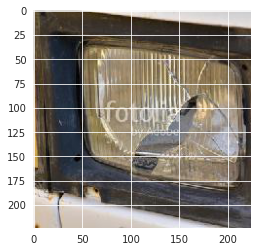

In [ ]:
img_path=r'./MyDrive/MyDrive/archive/image/1.jpeg'
img=plt.imread(img_path)
print (img.shape)
imshow(img)


### define function to preprocess the dataframe and create train, test and valid data frames

In [ ]:
def preprocess (sdir,csvpath, trsplit, vsplit):    
    df=pd.read_csv(csvpath)
    print (df.head())    
    df=df.copy()
    df=df.drop('Unnamed: 0', axis=1)
    print (df.head())
    df.columns=['filepaths', 'labels']
    df['filepaths']= df['filepaths'].apply(lambda x: os.path.join(sdir,x))
    df['labels']=df['labels'].astype(str) 
    print (df.head())
    # split df into train_df, test_df and valid_df
    strat=df['labels']
    dsplit=vsplit/(1-trsplit)
    train_df, dummy_df=train_test_split(df, train_size=trsplit, shuffle=True, random_state=123, stratify=strat)
    strat=dummy_df['labels']
    valid_df, test_df=train_test_split(dummy_df, train_size=dsplit, shuffle=True, random_state=123, stratify=strat)
    print('train_df length: ', len(train_df), '  test_df length: ',len(test_df), '  valid_df length: ', len(valid_df))
    # check that each dataframe has the same number of classes to prevent model.fit errors
    trcount=len(train_df['labels'].unique())
    tecount=len(test_df['labels'].unique())
    vcount=len(valid_df['labels'].unique())
    if trcount != tecount :         
        msg='** WARNING ** number of classes in training set not equal to number of classes in test set'
        print_in_color(msg, (255,0,0), (55,65,80))
        msg='This will throw an error in either model.evaluate or model.predict'
        print_in_color(msg, (255,0,0), (55,65,80))
    if trcount != vcount:
        msg='** WARNING ** number of classes in training set not equal to number of classes in validation set' 
        print_in_color(msg, (255,0,0), (55,65,80))
        msg=' this will throw an error in model.fit'
        print_in_color(msg, (255,0,0), (55,65,80))
        print ('train df class count: ', trcount, 'test df class count: ', tecount, ' valid df class count: ', vcount) 
        ans=input('Enter C to continue execution or H to halt execution')
        if ans =='H' or ans == 'h':
            print_in_color('Halting Execution', (255,0,0), (55,65,80))
            import sys
            sys.exit('program halted by user')            
    print(list(train_df['labels'].value_counts()))
    return train_df, test_df, valid_df
    

### call preprocessor function

In [ ]:
sdir=r'./MyDrive/MyDrive/archive'
csvpath=r'./MyDrive/MyDrive/archive/data.csv'
# create your own train, test and valid data frames
trsplit=.9 # set % of images to use for training
vsplit= .05 # set % of images to use for validation
# Note % used for test is 1-trsplit - vsplit = .05
train_df, test_df, valid_df= preprocess(sdir,csvpath, trsplit, vsplit)

   Unnamed: 0         image       classes
0           0  image/0.jpeg       unknown
1           1  image/1.jpeg     head_lamp
2           2  image/2.jpeg  door_scratch
3           3  image/3.jpeg     head_lamp
4           4  image/4.jpeg       unknown
          image       classes
0  image/0.jpeg       unknown
1  image/1.jpeg     head_lamp
2  image/2.jpeg  door_scratch
3  image/3.jpeg     head_lamp
4  image/4.jpeg       unknown
                                filepaths        labels
0  ./MyDrive/MyDrive/archive/image/0.jpeg       unknown
1  ./MyDrive/MyDrive/archive/image/1.jpeg     head_lamp
2  ./MyDrive/MyDrive/archive/image/2.jpeg  door_scratch
3  ./MyDrive/MyDrive/archive/image/3.jpeg     head_lamp
4  ./MyDrive/MyDrive/archive/image/4.jpeg       unknown
train_df length:  1434   test_df length:  80   valid_df length:  80
[494, 173, 147, 139, 123, 122, 120, 116]


### The data set is not balanced. Set max_samples to 300. This will limit the 
### maximum number of samples in a class to 300. function balance will then
### create augmented images so each class contains 300 samples

In [ ]:
max_samples= 300
min_samples=0
column='labels'
working_dir = r'./MyDrive/MyDrive/archive'
img_size=(224,224)
train_df=balance(train_df,max_samples, min_samples, column, working_dir, img_size)

Original Number of classes in dataframe:  8
[300, 173, 147, 139, 123, 122, 120, 116]
Found 139 validated image filenames.
Found 123 validated image filenames.
Found 122 validated image filenames.
Found 120 validated image filenames.
Found 116 validated image filenames.
Found 173 validated image filenames.
Found 147 validated image filenames.
Total Augmented images created=  1160
[300, 300, 300, 300, 300, 300, 300, 300]


### The train_f dataframe is now balanced with 300 samples per class

### create train, test and validation generators

In [ ]:
channels=3
batch_size=30
img_shape=(img_size[0],img_size[1], channels)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):    
    return img  # EfficientNet expects pixelsin range 0 to 255 so no scaling is required
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=trgen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)
train_steps=int(np.ceil(len(train_gen.labels)/batch_size))

test batch size:  80   test steps:  1
Found 2400 validated image filenames belonging to 8 classes.
Found 80 validated image filenames belonging to 8 classes.
Found 80 validated image filenames belonging to 8 classes.
['bumper_dent', 'bumper_scratch', 'door_dent', 'door_scratch', 'glass_shatter', 'head_lamp', 'tail_lamp', 'unknown']


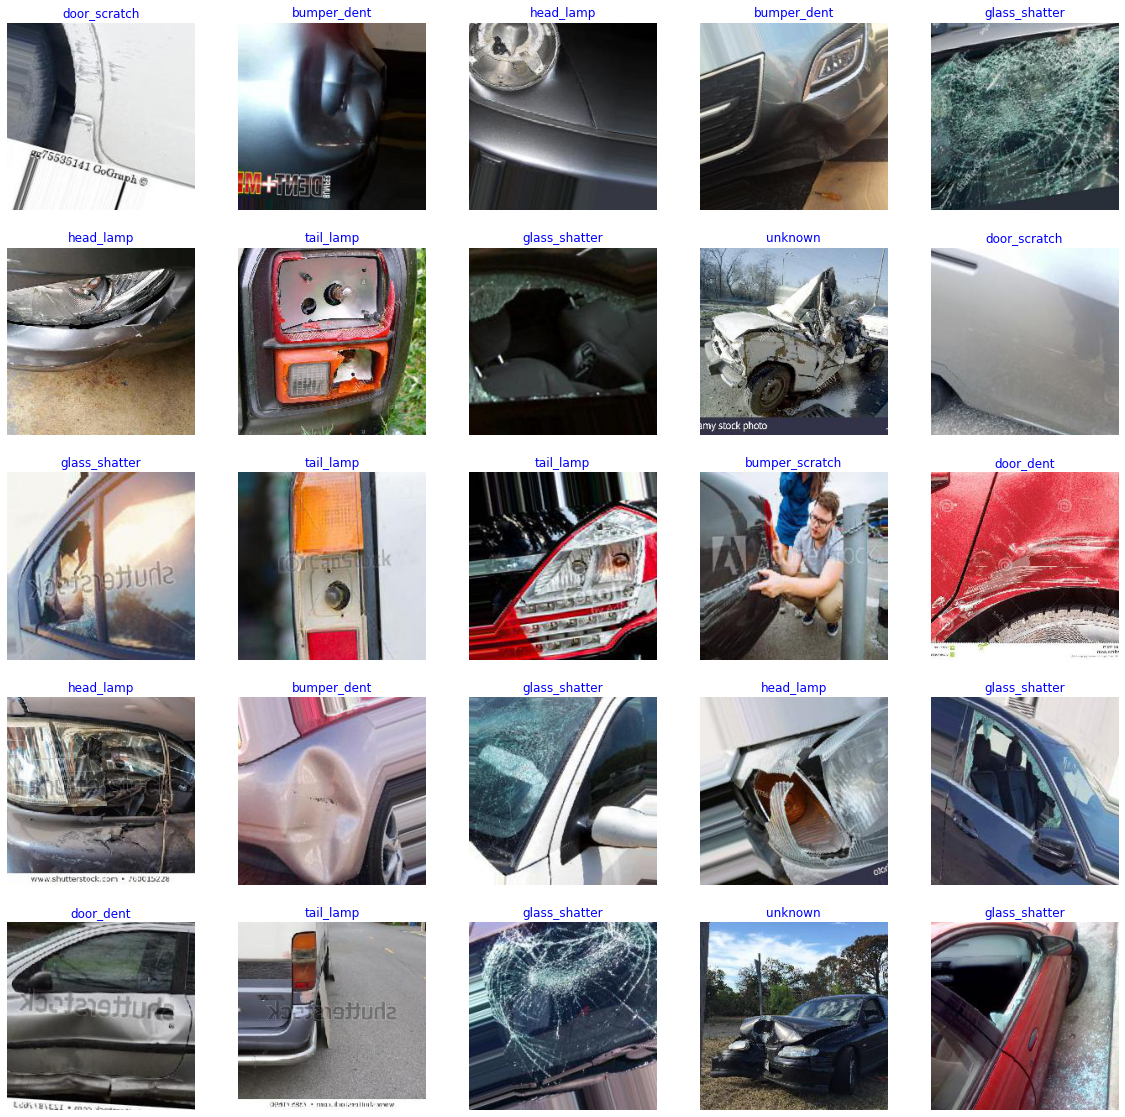

In [ ]:
show_image_samples(train_gen)


In [ ]:
model_name='EfficientNetB3'
base_model=tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1 )(x)
x = Dense(256, activation='relu')(x)
x=Dropout(rate=.5, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adam(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                            

In [ ]:
epochs =40
patience= 5 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =5 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
ask_epoch=None # number of epochs to run before asking if you want to halt training
batches=train_steps

model_name = 'EfficientNetB3_Damage_prediction_model_base.hdf5'
model_path = os.path.join(working_dir,model_name)
checkpoint = ModelCheckpoint(model_path, save_best_only=True)

callbacks=[checkpoint, LRA(model=model,base_model= base_model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]

history=model.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 initializing callback starting train with base_model trainable

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

 1 /40     1.495   60.250   1.09230  76.250   0.00100  0.00100  accuracy     0.00    50.92  

 2 /40     0.760   79.042   8.46712  73.750   0.00100  0.00100  accuracy    31.19    31.49  

 3 /40     0.616   85.458   4.05136  63.750   0.00100  0.00100  accuracy     8.12    31.26  

 4 /40     0.775   82.625   8.17999  58.750   0.00100  0.00100  accuracy    -3.32    31.52  

 5 /40     0.560   85.917   0.90951  80.000   0.00100  0.00100  accuracy     0.54    34.34  

 6 /40     0.311   91.333   0.43724  90.000   0.00100  0.00100  val_loss    51.93    35.24  

 7 /40     0.207   94.292   0.67205  88.750   0.00100  0.00100  val_loss    -53.70   31.57  

 8 /40     0.281   92.917   0.65492  86.250   0.00100  0.00100  val_loss    -49.79   31.38  

 9 /40     0.244   93.208   1.09593  85.000   0.00100  0.00100  val_loss   -150.65   31.35

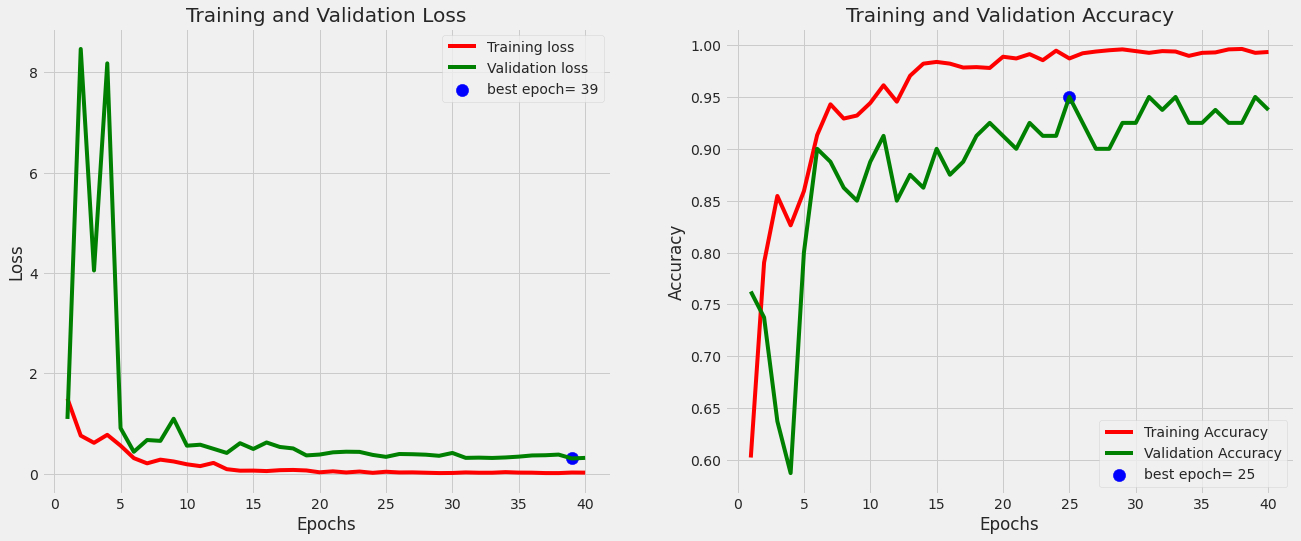

1/1 [==============================] - 0s 378ms/step - loss: 0.3072 - accuracy: 0.9000
accuracy on the test set is 90.00 %

model was saved as ./MyDrive/MyDrive/archive/EfficientNetB3_Damage_prediction_model_base.hdf5-instruments-89.99.h5

class csv file was saved as ./MyDrive/MyDrive/archive/class_dict.csv



In [ ]:
#working_dir=r'./'
tr_plot(history,0)
subject='instruments'
acc=model.evaluate( test_gen, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
generator=train_gen
scale = 1
model_save_loc, csv_save_loc=saver(working_dir, model, model_name, subject, acc, img_size, scale,  generator)

          Filename                Predicted Class                True Class           Probability   

      image/1002.jpeg                 unknown                   bumper_dent             0.4286

       image/269.jpeg                head_lamp                    unknown               0.9904

       image/289.jpeg                door_dent                  door_scratch            0.8988

       image/659.jpeg               door_scratch                 door_dent              0.5339

       image/169.jpeg                 unknown                   door_scratch            0.4843

      image/1121.jpeg              glass_shatter                  unknown               0.8024

      image/1290.jpeg                 unknown                    head_lamp              0.7437

      image/1466.jpeg                 unknown                    head_lamp              0.6127



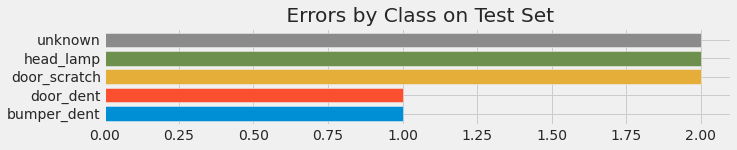

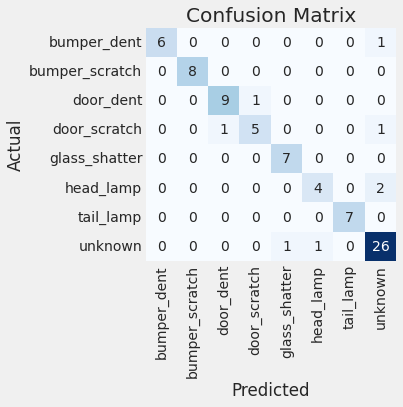

Classification Report:
----------------------
                 precision    recall  f1-score   support

   bumper_dent       1.00      0.86      0.92         7
bumper_scratch       1.00      1.00      1.00         8
     door_dent       0.90      0.90      0.90        10
  door_scratch       0.83      0.71      0.77         7
 glass_shatter       0.88      1.00      0.93         7
     head_lamp       0.80      0.67      0.73         6
     tail_lamp       1.00      1.00      1.00         7
       unknown       0.87      0.93      0.90        28

      accuracy                           0.90        80
     macro avg       0.91      0.88      0.89        80
  weighted avg       0.90      0.90      0.90        80

Over all F1 Score :  0.9


In [ ]:
print_code=10 # set max value for number of mis-classified images files to print
preds=model.predict(test_gen) # make predictions on test set
print_info( test_gen, preds, print_code, working_dir, subject )  

### create the model

In [ ]:
model_name='EfficientNetB3'
base_model=tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

43950080/43941136 [==============================] - 0s 0us/step


In [ ]:
epochs =40
patience= 5 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =5 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
ask_epoch=10 # number of epochs to run before asking if you want to halt training
batches=train_steps

model_name = 'EfficientNetB3_Damage_prediction_model.hdf5'
model_path = os.path.join(working_dir,model_name)
checkpoint = ModelCheckpoint(model_path, save_best_only=True)

callbacks=[checkpoint, LRA(model=model,base_model= base_model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]

history=model.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 initializing callback starting train with base_model trainable

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

 1 /40     8.531   59.958   7.70367  77.500   0.00100  0.00100  accuracy     0.00    163.57 

 2 /40     6.562   87.833   6.06490  83.750   0.00100  0.00100  accuracy    46.49    35.77  

 3 /40     5.410   94.333   5.09715  90.000   0.00100  0.00100  val_loss    15.96    35.80  

 4 /40     4.488   96.917   4.23884  92.500   0.00100  0.00100  val_loss    16.84    35.55  

 5 /40     3.718   98.333   3.52931  93.750   0.00100  0.00100  val_loss    16.74    35.39  

 6 /40     3.071   98.667   2.94636  93.750   0.00100  0.00100  val_loss    16.52    35.31  

 7 /40     2.531   99.167   2.46040  93.750   0.00100  0.00100  val_loss    16.49    35.64  

 8 /40     2.079   99.250   2.04064  95.000   0.00100  0.00100  val_loss    17.06    35.16  

 9 /40     1.712   99.292   1.69885  93.750   0.00100  0.00100  val_loss    16.75    35.56

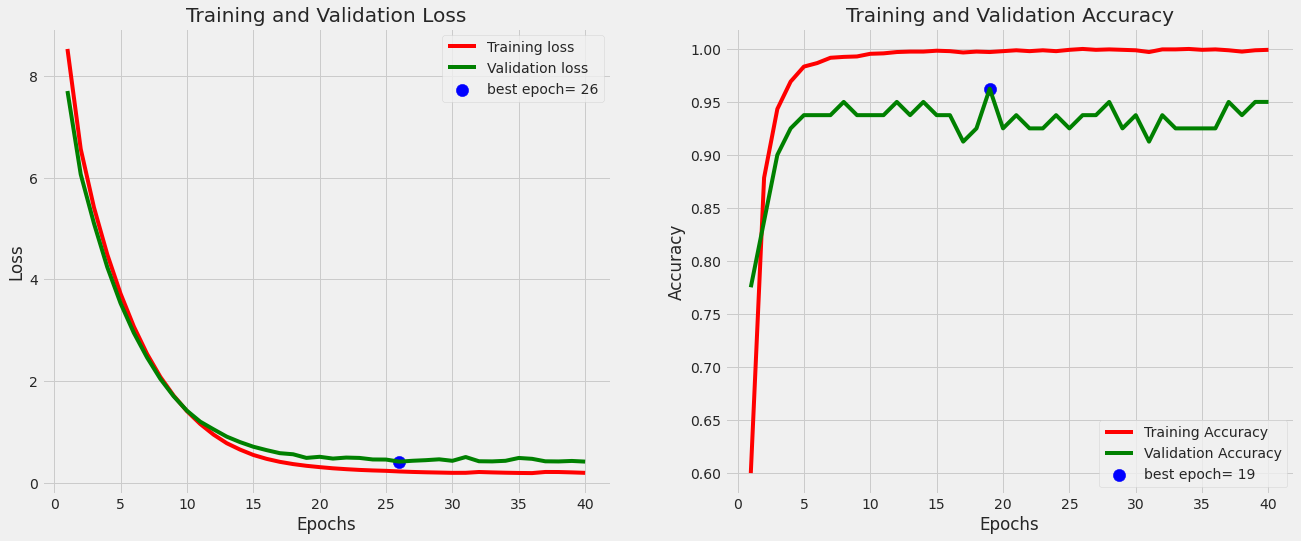

1/1 [==============================] - 1s 748ms/step - loss: 0.4095 - accuracy: 0.9375
accuracy on the test set is 93.75 %

model was saved as ./MyDrive/MyDrive/archive/EfficientNetB3_Damage_prediction_model.hdf5-instruments-93.75.h5

class csv file was saved as ./MyDrive/MyDrive/archive/class_dict.csv



In [ ]:
#working_dir=r'./'
tr_plot(history,0)
subject='instruments'
acc=model.evaluate( test_gen, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
generator=train_gen
scale = 1
model_save_loc, csv_save_loc=saver(working_dir, model, model_name, subject, acc, img_size, scale,  generator)

          Filename                Predicted Class                True Class           Probability   

      image/1002.jpeg              glass_shatter                bumper_dent             0.5385

       image/659.jpeg              bumper_scratch                door_dent              0.3847

       image/169.jpeg              glass_shatter                door_scratch            0.7451

       image/183.jpeg                 unknown                   bumper_dent             0.9730

        image/5.jpeg                 door_dent                    unknown               0.5249



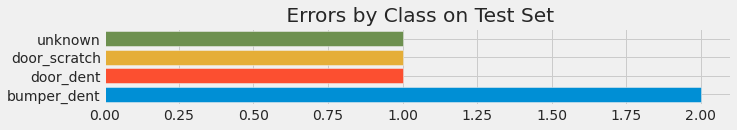

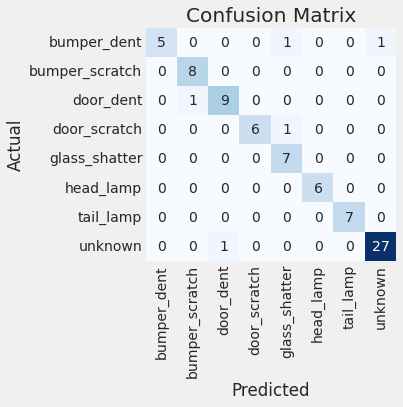

Classification Report:
----------------------
                 precision    recall  f1-score   support

   bumper_dent       1.00      0.71      0.83         7
bumper_scratch       0.89      1.00      0.94         8
     door_dent       0.90      0.90      0.90        10
  door_scratch       1.00      0.86      0.92         7
 glass_shatter       0.78      1.00      0.88         7
     head_lamp       1.00      1.00      1.00         6
     tail_lamp       1.00      1.00      1.00         7
       unknown       0.96      0.96      0.96        28

      accuracy                           0.94        80
     macro avg       0.94      0.93      0.93        80
  weighted avg       0.94      0.94      0.94        80

Over all F1 Score :  0.9375


In [ ]:
print_code=10 # set max value for number of mis-classified images files to print
preds=model.predict(test_gen) # make predictions on test set
print_info( test_gen, preds, print_code, working_dir, subject )  

# Attnetion Mechanism Implementation on EfficientNetB3

In [ ]:
shape = 380
IMG_SIZE = 380

num_classes = 8
img_shape = (IMG_SIZE, IMG_SIZE, 3)
#inputs = Input(img_shape)
input_tensor = Input(shape=(shape, shape, 3))
# effB4_model=tf.keras.applications.EfficientNetB4(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 

base_model = tf.keras.applications.EfficientNetB3(input_tensor=input_tensor, weights='imagenet', include_top=False)
# effB4_model.trainable = True
effB3_outputs = base_model.output

# effB4_depth = effB4_model.layers[0].compute_output_shape(img_shape)[-1]
effB3_depth = 1
bn_outputs = BatchNormalization(name='BatchNormalization')(effB3_outputs)

# here we do an attention mechanism to turn pixels in the GAP on an off
atten_outputs = Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu')(bn_outputs)
atten_outputs = Conv2D(32, kernel_size = (2,2), padding = 'same', activation = 'relu')(atten_outputs)
atten_outputs = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(atten_outputs)
atten_outputs = Conv2D(1, kernel_size = (1,1), padding = 'valid', activation = 'sigmoid')(atten_outputs)

# fan it out to all of the channels
weights = np.ones((1, 1, 1, effB3_depth))
outputs_up_c2 = Conv2D(effB3_depth, kernel_size = (1,1), padding = 'same', activation = 'linear', use_bias = False, weights = [weights])
outputs_up_c2.trainable = False
atten_outputs = outputs_up_c2(atten_outputs)

multiply_outputs = multiply([atten_outputs, bn_outputs], name='Multiply')
gap_features_ouputs = GlobalAveragePooling2D()(multiply_outputs)
gap_mask_ouputs = GlobalAveragePooling2D()(atten_outputs)

# to account for missing values from the attention model
outputs = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features_ouputs, gap_mask_ouputs])
outputs = Dropout(0.5)(outputs)
outputs = Dense(256, activation = 'relu')(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(num_classes, activation = 'softmax')(outputs)

# adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
losses = ['categorical_crossentropy']
# model.compile(adam, loss=losses, metrics=['accuracy'])
# checkpoint = ModelCheckpoint('damage_type_model.hdf5', save_best_only=True)
# LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience = 15)
model_atten_b3 = Model(inputs = [input_tensor], outputs = [outputs])
model_atten_b3.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy'])
model_atten_b3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 380, 380, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_7 (Rescaling)        (None, 380, 380, 3)  0           ['input_8[0][0]']                
                                                                                                  
 normalization_7 (Normalization  (None, 380, 380, 3)  7          ['rescaling_7[0][0]']            
 )                                                                                                
                                                                                            

In [ ]:
epochs =40
patience= 5 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =5 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
ask_epoch=40 # number of epochs to run before asking if you want to halt training
batches=train_steps

model_name = 'EfficientNetB3_Damage_prediction_model_withAttemtion.hdf5'
model_path = os.path.join(working_dir,model_name)
checkpoint = ModelCheckpoint(model_path, save_best_only=True)

callbacks=[checkpoint, LRA(model=model_atten_b3,base_model= base_model ,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]

history_eff3_atten=model_atten_b3.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 initializing callback starting train with base_model trainable

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

 1 /40     1.137   60.500   0.58744  80.000   0.00100  0.00100  accuracy     0.00    50.74  

 2 /40     0.317   90.333   0.42751  88.750   0.00100  0.00100  val_loss    27.22    34.03  

 3 /40     0.182   94.208   0.44992  90.000   0.00100  0.00100  val_loss    -5.24    32.37  

 4 /40     0.096   96.792   0.44909  90.000   0.00100  0.00100  val_loss    -5.05    32.09  

 5 /40     0.066   97.750   0.44364  88.750   0.00100  0.00100  val_loss    -3.77    32.16  

 6 /40     0.062   97.917   0.48516  88.750   0.00100  0.00100  val_loss    -13.48   32.45  

 7 /40     0.046   98.708   0.47634  90.000   0.00100  0.00050  val_loss    -11.42   31.89  

 8 /40     0.158   95.167   0.37738  88.750   0.00050  0.00050  val_loss    11.73    34.42  

 9 /40     0.101   97.083   0.45230  88.750   0.00050  0.00050  val_loss    -19.85   32.53

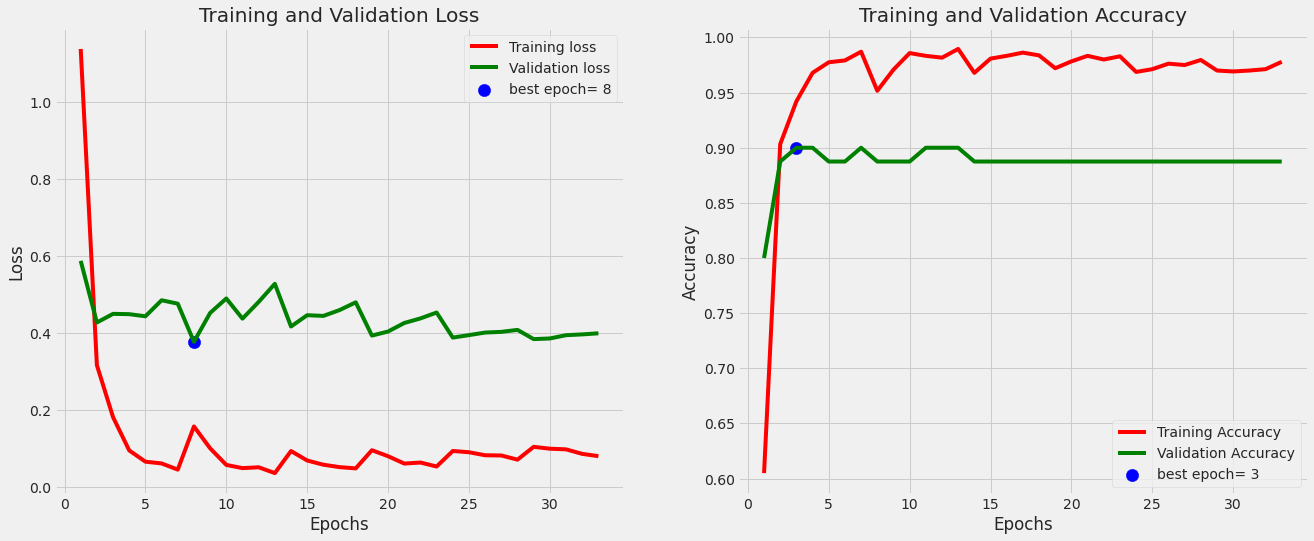

1/1 [==============================] - 1s 527ms/step - loss: 0.1886 - accuracy: 0.9500
accuracy on the test set is 95.00 %

model was saved as ./MyDrive/MyDrive/archive/EfficientNetB3_Damage_prediction_model_withAttemtion.hdf5-instruments-94.99.h5

class csv file was saved as ./MyDrive/MyDrive/archive/class_dict.csv



In [ ]:
tr_plot(history_eff3_atten,0)
subject='instruments'
acc=model_atten_b3.evaluate( test_gen, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
generator=train_gen
scale = 1
model_save_loc, csv_save_loc=saver(working_dir, model_atten_b3, model_name, subject, acc, img_size, scale,  generator)

          Filename                Predicted Class                True Class           Probability   

      image/1002.jpeg              glass_shatter                bumper_dent             0.8408

       image/169.jpeg                 unknown                   door_scratch            0.4271

       image/707.jpeg               bumper_dent                  tail_lamp              0.9007

       image/146.jpeg                 unknown                   door_scratch            0.4283



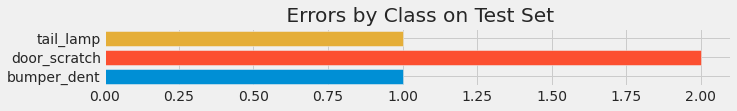

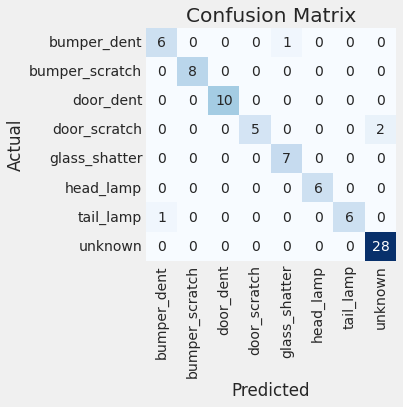

Classification Report:
----------------------
                 precision    recall  f1-score   support

   bumper_dent       0.86      0.86      0.86         7
bumper_scratch       1.00      1.00      1.00         8
     door_dent       1.00      1.00      1.00        10
  door_scratch       1.00      0.71      0.83         7
 glass_shatter       0.88      1.00      0.93         7
     head_lamp       1.00      1.00      1.00         6
     tail_lamp       1.00      0.86      0.92         7
       unknown       0.93      1.00      0.97        28

      accuracy                           0.95        80
     macro avg       0.96      0.93      0.94        80
  weighted avg       0.95      0.95      0.95        80

Over all F1 Score :  0.9500000000000001


In [ ]:
print_code=10 # set max value for number of mis-classified images files to print
preds=model_atten_b3.predict(test_gen) # make predictions on test set
print_info( test_gen, preds, print_code, working_dir, subject )  

# EfficientNetB3 with Regularizers and LR @0.0001

In [ ]:
model_name='EfficientNetB3'
base_model=tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
new_input = base_model.input
hidden_layer = base_model.layers[-1].output

image_features_extract_efficient_model = keras.Model(new_input,hidden_layer)
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006), bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.5, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=.0001), loss='categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                            

In [ ]:
epochs =40
patience= 5 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =5 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
ask_epoch=10 # number of epochs to run before asking if you want to halt training
batches=train_steps

model_name = 'EfficientNetB3_Damage_prediction_model.hdf5'
model_path = os.path.join(working_dir,model_name)
checkpoint = ModelCheckpoint(model_path, save_best_only=True)

callbacks=[checkpoint, LRA(model=model,base_model= base_model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]

history=model.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 initializing callback starting train with base_model trainable

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

 1 /40    10.239   21.321   9.17709  50.000   0.00010  0.00010  accuracy     0.00    72.03  

 2 /40     9.321   41.929   8.67288  67.500   0.00010  0.00010  accuracy    96.65    58.43  

 3 /40     8.771   56.321   8.41754  72.500   0.00010  0.00010  accuracy    34.33    56.87  

 4 /40     8.402   65.321   8.18408  72.500   0.00010  0.00010  accuracy    15.98    56.42  

 5 /40     8.110   71.036   7.97241  76.250   0.00010  0.00010  accuracy     8.75    56.14  

 6 /40     7.899   75.250   7.77820  77.500   0.00010  0.00010  accuracy     5.93    55.94  

 7 /40     7.646   80.857   7.60976  78.750   0.00010  0.00010  accuracy     7.45    56.32  

 8 /40     7.416   83.929   7.41634  80.000   0.00010  0.00010  accuracy     3.80    56.19  

 9 /40     7.228   85.643   7.25485  83.750   0.00010  0.00010  accuracy     2.04    55.80

### evaluate model on the test set then save the model

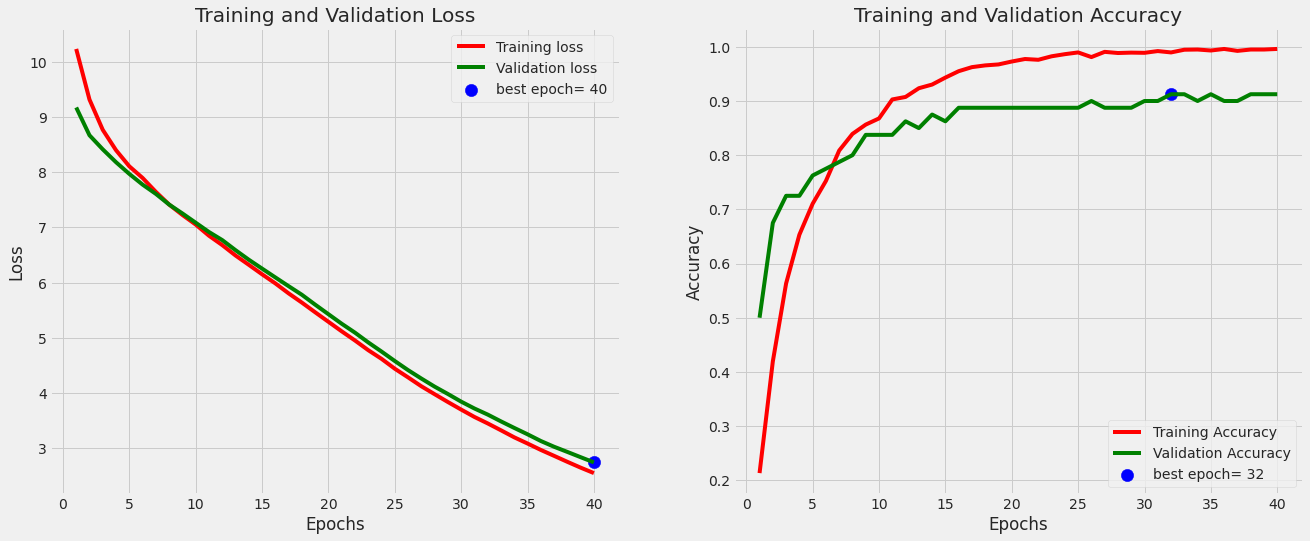

1/1 [==============================] - 2s 2s/step - loss: 2.6629 - accuracy: 0.9250
accuracy on the test set is 92.50 %

model was saved as ./MyDrive/MyDrive/archive/EfficientNetB3_Damage_prediction_model.hdf5-instruments-92.50.h5

class csv file was saved as ./MyDrive/MyDrive/archive/class_dict.csv



In [ ]:
#working_dir=r'./'
tr_plot(history,0)
subject='instruments'
acc=model.evaluate( test_gen, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
generator=train_gen
scale = 1
model_save_loc, csv_save_loc=saver(working_dir, model, model_name, subject, acc, img_size, scale,  generator)

### make predictions on test set and generate confusion matrix and classification report

          Filename                Predicted Class                True Class           Probability   

      image/1002.jpeg              glass_shatter                bumper_dent             0.3021

      image/1427.jpeg               bumper_dent                  tail_lamp              0.3318

       image/169.jpeg                door_dent                  door_scratch            0.3389

      image/1290.jpeg              bumper_scratch                head_lamp              0.4024

       image/815.jpeg               door_scratch                bumper_dent             0.3932

       image/146.jpeg                 unknown                   door_scratch            0.4498



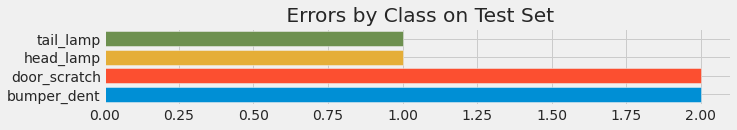

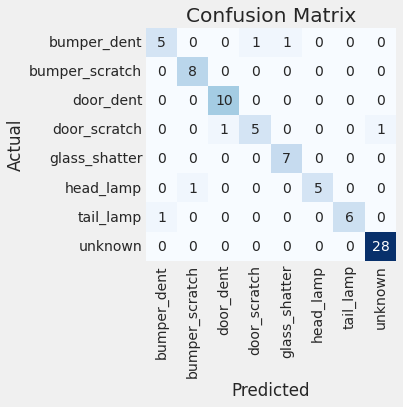

Classification Report:
----------------------
                 precision    recall  f1-score   support

   bumper_dent       0.83      0.71      0.77         7
bumper_scratch       0.89      1.00      0.94         8
     door_dent       0.91      1.00      0.95        10
  door_scratch       0.83      0.71      0.77         7
 glass_shatter       0.88      1.00      0.93         7
     head_lamp       1.00      0.83      0.91         6
     tail_lamp       1.00      0.86      0.92         7
       unknown       0.97      1.00      0.98        28

      accuracy                           0.93        80
     macro avg       0.91      0.89      0.90        80
  weighted avg       0.93      0.93      0.92        80



In [ ]:
print_code=10 # set max value for number of mis-classified images files to print
preds=model.predict(test_gen) # make predictions on test set
print_info( test_gen, preds, print_code, working_dir, subject )  

### to test the classifier kernel create a directory with a single image in it

In [ ]:
store_path=os.path.join(working_dir, 'storage')
if os.path.isdir(store_path):
    shutil.rmtree(store_path)
os.mkdir(store_path)
# input an image to be predicted
img=cv2.imread(img_path,  cv2.IMREAD_REDUCED_COLOR_2)
file_name=os.path.split(img_path)[1]
dst_path=os.path.join(store_path, file_name)
cv2.imwrite(dst_path, img)
# check if the directory was created and image stored
print (os.listdir(store_path))

['1.jpeg']


### use the predictor function to classify the single image

In [ ]:
csv_path=csv_save_loc # path to class_dict.csv
model_path=model_save_loc # path to the trained model
klass, prob, img, df =predictor(store_path, csv_path,  model_path, averaged=True, verbose=False) # run the classifier
msg=f' image is of instrument {klass} with a probability of {prob * 100: 6.2f} %'
plt.axis('off')
plt.imshow(img)
print_in_color(msg, (0,255,255), (65,85,55))

NameError: ignored

# Model with EfficientNetB4

In [ ]:
model_name='EfficientNetB4'
base_model=tf.keras.applications.EfficientNetB4(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
new_input = base_model.input
hidden_layer = base_model.layers[-1].output

image_features_extract_efficient_model = keras.Model(new_input,hidden_layer)
x=keras.layers.BatchNormalization(axis=-1)(x)
x = Dense(256, activation='relu')(x)
x=Dropout(rate=.5, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)
model_b4=Model(inputs=base_model.input, outputs=output)
model_b4.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

71696384/71686520 [==============================] - 1s 0us/step


In [ ]:
model_b4.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']    

In [ ]:
epochs =40
patience= 5 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =5 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
ask_epoch=15 # number of epochs to run before asking if you want to halt training
batches=train_steps

model_name = 'EfficientNetB4_Damage_prediction_model_plain.hdf5'
model_path = os.path.join(working_dir,model_name)
checkpoint = ModelCheckpoint(model_path, save_best_only=True)

callbacks=[checkpoint, LRA(model=model_b4,base_model= base_model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]

history_eff4=model_b4.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 initializing callback starting train with base_model trainable

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

 1 /40     1.371   58.458   0.70252  80.000   0.00100  0.00100  accuracy     0.00    89.70  

 2 /40     0.371   87.583   0.45146  90.000   0.00100  0.00100  accuracy    49.82    46.20  

 3 /40     0.213   92.917   0.48410  85.000   0.00100  0.00100  val_loss    -7.23    40.56  

 4 /40     0.118   96.417   0.51647  86.250   0.00100  0.00100  val_loss    -14.40   43.29  

 5 /40     0.065   97.708   0.51831  86.250   0.00100  0.00100  val_loss    -14.81   40.38  

 6 /40     0.062   98.250   0.47679  87.500   0.00100  0.00100  val_loss    -5.61    40.81  

 7 /40     0.046   98.708   0.44688  88.750   0.00100  0.00100  val_loss     1.01    46.55  

 8 /40     0.033   98.917   0.54097  86.250   0.00100  0.00100  val_loss    -21.06   40.67  

 9 /40     0.036   98.708   0.42497  87.500   0.00100  0.00100  val_loss     4.90    46.19

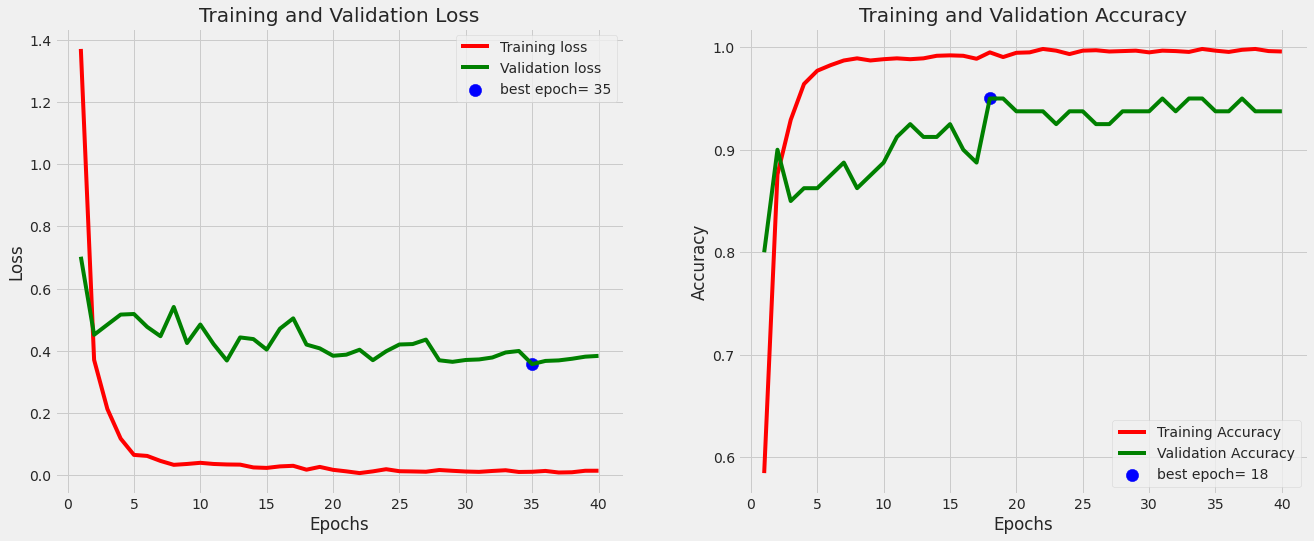

1/1 [==============================] - 1s 839ms/step - loss: 0.2336 - accuracy: 0.8750
accuracy on the test set is 87.50 %

model was saved as ./MyDrive/MyDrive/archive/EfficientNetB4_Damage_prediction_model_plain.hdf5-instruments-87.5.h5

class csv file was saved as ./MyDrive/MyDrive/archive/class_dict.csv



In [ ]:
tr_plot(history_eff4,0)
subject='instruments'
acc=model_b4.evaluate( test_gen, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
generator=train_gen
scale = 1
model_save_loc, csv_save_loc=saver(working_dir, model_b4, model_name, subject, acc, img_size, scale,  generator)

          Filename                Predicted Class                True Class           Probability   

       image/659.jpeg                 unknown                    door_dent              0.8607

      image/1314.jpeg                tail_lamp                  bumper_dent             0.9070

       image/141.jpeg                head_lamp                 glass_shatter            0.2879

       image/169.jpeg              glass_shatter                door_scratch            0.5669

       image/976.jpeg               door_scratch                 door_dent              0.8976

       image/797.jpeg              glass_shatter                 head_lamp              0.5015

      image/1121.jpeg              glass_shatter                  unknown               0.6740

       image/183.jpeg                 unknown                   bumper_dent             0.6983

      image/1290.jpeg                 unknown                    head_lamp              0.6139

       image/558.jpeg             

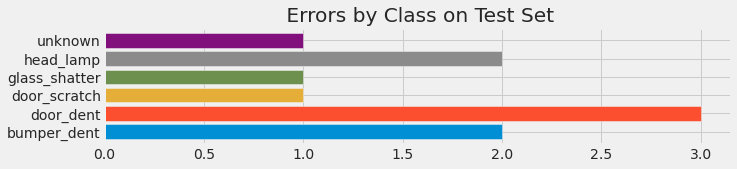

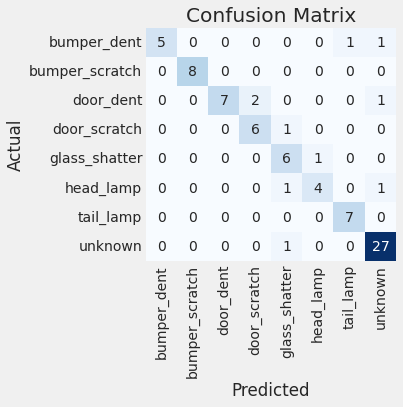

Classification Report:
----------------------
                 precision    recall  f1-score   support

   bumper_dent       1.00      0.71      0.83         7
bumper_scratch       1.00      1.00      1.00         8
     door_dent       1.00      0.70      0.82        10
  door_scratch       0.75      0.86      0.80         7
 glass_shatter       0.67      0.86      0.75         7
     head_lamp       0.80      0.67      0.73         6
     tail_lamp       0.88      1.00      0.93         7
       unknown       0.90      0.96      0.93        28

      accuracy                           0.88        80
     macro avg       0.87      0.84      0.85        80
  weighted avg       0.89      0.88      0.87        80

Over all F1 Score :  0.875


In [ ]:
print_code=10 # set max value for number of mis-classified images files to print
preds=model_b4.predict(test_gen) # make predictions on test set
print_info( test_gen, preds, print_code, working_dir, subject )  

# EfficientNetB4 with hypertuning parameters

In [ ]:
model_name='EfficientNetB4'
base_model=tf.keras.applications.EfficientNetB4(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
new_input = base_model.input
hidden_layer = base_model.layers[-1].output

image_features_extract_efficient_model = keras.Model(new_input,hidden_layer)
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006), bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)
model_b4=Model(inputs=base_model.input, outputs=output)
model_b4.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
model_b4.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                            

In [ ]:
epochs =40
patience= 5 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =5 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
ask_epoch=15 # number of epochs to run before asking if you want to halt training
batches=train_steps

model_name = 'EfficientNetB4_Damage_prediction_model.hdf5'
model_path = os.path.join(working_dir,model_name)
checkpoint = ModelCheckpoint(model_path, save_best_only=True)

callbacks=[checkpoint, LRA(model=model_b4,base_model= base_model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]

history_eff4=model_b4.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 initializing callback starting train with base_model trainable

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

 1 /40     8.720   58.042   7.48976  83.750   0.00100  0.00100  accuracy     0.00    68.41  

 2 /40     6.672   85.917   6.05008  92.500   0.00100  0.00100  accuracy    48.03    45.75  

 3 /40     5.474   94.833   5.10932  95.000   0.00100  0.00100  val_loss    15.55    45.65  

 4 /40     4.569   97.375   4.29183  95.000   0.00100  0.00100  val_loss    16.00    45.73  

 5 /40     3.838   98.375   3.63845  96.250   0.00100  0.00100  val_loss    15.22    45.89  

 6 /40     3.216   98.583   3.10301  92.500   0.00100  0.00100  val_loss    14.72    46.30  

 7 /40     2.700   98.958   2.62011  93.750   0.00100  0.00100  val_loss    15.56    45.52  

 8 /40     2.256   99.292   2.23416  95.000   0.00100  0.00100  val_loss    14.73    45.66  

 9 /40     1.893   99.458   1.88546  95.000   0.00100  0.00100  val_loss    15.61    45.48

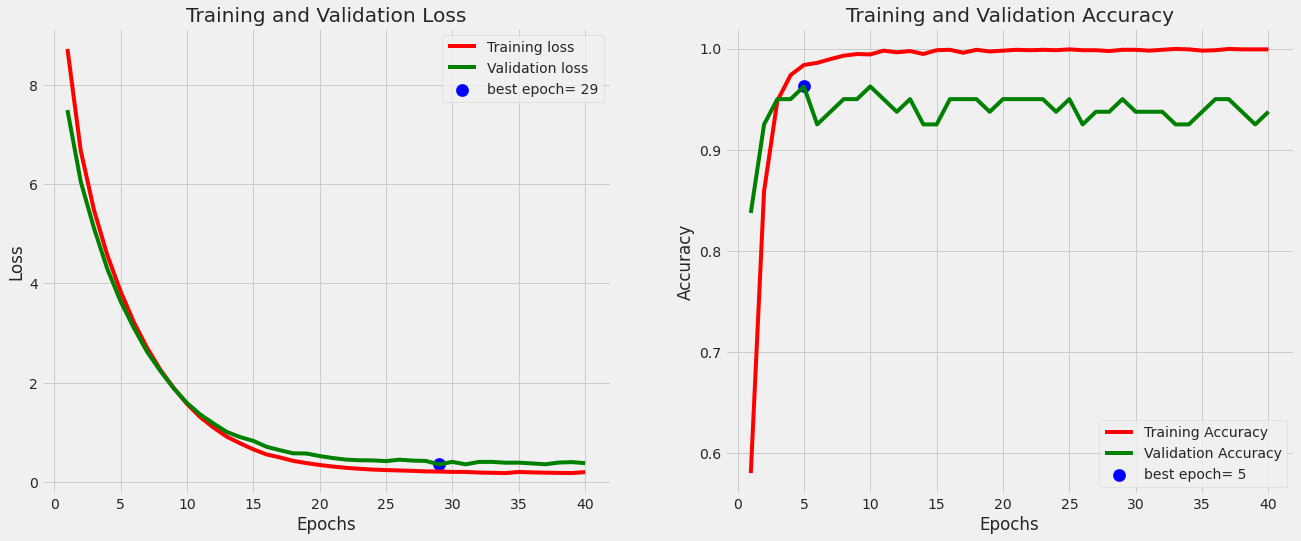

1/1 [==============================] - 0s 477ms/step - loss: 0.3737 - accuracy: 0.9125
accuracy on the test set is 91.25 %

model was saved as ./MyDrive/MyDrive/archive/EfficientNetB4_Damage_prediction_model.hdf5-instruments-91.25.h5

class csv file was saved as ./MyDrive/MyDrive/archive/class_dict.csv



In [ ]:
tr_plot(history_eff4,0)
subject='instruments'
acc=model_b4.evaluate( test_gen, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
generator=train_gen
scale = 1
model_save_loc, csv_save_loc=saver(working_dir, model_b4, model_name, subject, acc, img_size, scale,  generator)

          Filename                Predicted Class                True Class           Probability   

      image/1002.jpeg                head_lamp                  bumper_dent             0.4830

       image/659.jpeg              bumper_scratch                door_dent              0.4636

       image/169.jpeg                door_dent                  door_scratch            0.8023

       image/534.jpeg                 unknown                    door_dent              0.5831

       image/183.jpeg                 unknown                   bumper_dent             0.4962

      image/1290.jpeg                 unknown                    head_lamp              0.4214

       image/146.jpeg                 unknown                   door_scratch            0.6779



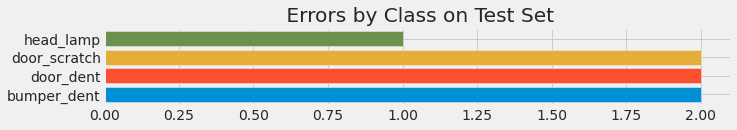

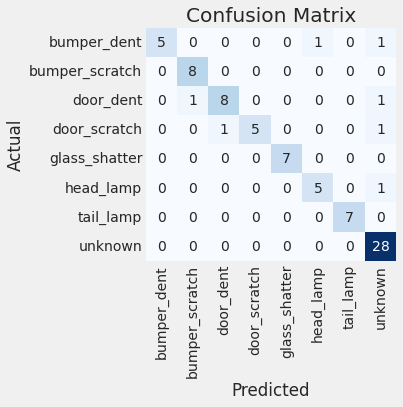

Classification Report:
----------------------
                 precision    recall  f1-score   support

   bumper_dent       1.00      0.71      0.83         7
bumper_scratch       0.89      1.00      0.94         8
     door_dent       0.89      0.80      0.84        10
  door_scratch       1.00      0.71      0.83         7
 glass_shatter       1.00      1.00      1.00         7
     head_lamp       0.83      0.83      0.83         6
     tail_lamp       1.00      1.00      1.00         7
       unknown       0.88      1.00      0.93        28

      accuracy                           0.91        80
     macro avg       0.94      0.88      0.90        80
  weighted avg       0.92      0.91      0.91        80

Over all F1 Score :  0.9125


In [ ]:
print_code=10 # set max value for number of mis-classified images files to print
preds=model_b4.predict(test_gen) # make predictions on test set
print_info( test_gen, preds, print_code, working_dir, subject )  

# EfficientNetB4 with Attention mechanism lr@0.001

In [ ]:
shape = 380
IMG_SIZE = 380

num_classes = 8
img_shape = (IMG_SIZE, IMG_SIZE, 3)
#inputs = Input(img_shape)
input_tensor = Input(shape=(shape, shape, 3))
# effB4_model=tf.keras.applications.EfficientNetB4(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 

base_model = tf.keras.applications.EfficientNetB4(input_tensor=input_tensor, weights='imagenet', include_top=False)
# effB4_model.trainable = True
effB4_outputs = base_model.output

# effB4_depth = effB4_model.layers[0].compute_output_shape(img_shape)[-1]
effB4_depth = 1792
bn_outputs = BatchNormalization(name='BatchNormalization')(effB4_outputs)

# here we do an attention mechanism to turn pixels in the GAP on an off
atten_outputs = Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu')(bn_outputs)
atten_outputs = Conv2D(32, kernel_size = (2,2), padding = 'same', activation = 'relu')(atten_outputs)
atten_outputs = Conv2D(16, kernel_size = (2,2), padding = 'same', activation = 'relu')(atten_outputs)
atten_outputs = Conv2D(1, kernel_size = (1,1), padding = 'valid', activation = 'sigmoid')(atten_outputs)

# fan it out to all of the channels
weights = np.ones((1, 1, 1, effB4_depth))
outputs_up_c2 = Conv2D(effB4_depth, kernel_size = (1,1), padding = 'same', activation = 'linear', use_bias = False, weights = [weights])
outputs_up_c2.trainable = False
atten_outputs = outputs_up_c2(atten_outputs)

multiply_outputs = multiply([atten_outputs, bn_outputs], name='Multiply')
gap_features_ouputs = GlobalAveragePooling2D()(multiply_outputs)
gap_mask_ouputs = GlobalAveragePooling2D()(atten_outputs)

# to account for missing values from the attention model
outputs = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features_ouputs, gap_mask_ouputs])
outputs = Dropout(0.5)(outputs)
outputs = Dense(128, activation = 'elu')(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(num_classes, activation = 'softmax')(outputs)

# adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
losses = ['categorical_crossentropy']
# model.compile(adam, loss=losses, metrics=['accuracy'])
# checkpoint = ModelCheckpoint('damage_type_model.hdf5', save_best_only=True)
# LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience = 15)
model_atten_b4 = Model(inputs = [input_tensor], outputs = [outputs])
model_atten_b4.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy'])
model_atten_b4.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 380, 380, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 380, 380, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization_3 (Normalization  (None, 380, 380, 3)  7          ['rescaling_3[0][0]']            
 )                                                                                                
                                                                                            

In [ ]:
epochs =40
patience= 5 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =5 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
ask_epoch=None # number of epochs to run before asking if you want to halt training
batches=train_steps

model_name = 'EfficientNetB4_Damage_prediction_model_withAttemtion.hdf5'
model_path = os.path.join(working_dir,model_name)
checkpoint = ModelCheckpoint(model_path, save_best_only=True)

callbacks=[checkpoint, LRA(model=model_atten_b4,base_model= base_model ,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]

history_eff4_atten=model_atten_b4.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 initializing callback starting train with base_model trainable

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

 1 /40     1.082   61.833   0.41707  87.500   0.00100  0.00100  accuracy     0.00    65.54  

 2 /40     0.261   92.250   0.46077  88.750   0.00100  0.00100  val_loss    -10.48   40.85  

 3 /40     0.134   95.667   0.38649  92.500   0.00100  0.00100  val_loss     7.33    43.98  

 4 /40     0.068   98.000   0.38686  92.500   0.00100  0.00100  val_loss    -0.10    40.42  

 5 /40     0.056   97.958   0.41108  91.250   0.00100  0.00100  val_loss    -6.36    40.89  

 6 /40     0.044   98.625   0.47308  92.500   0.00100  0.00100  val_loss    -22.41   39.63  

 7 /40     0.037   98.708   0.47637  91.250   0.00100  0.00100  val_loss    -23.26   40.46  

 8 /40     0.028   99.125   0.45773  92.500   0.00100  0.00050  val_loss    -18.43   40.54  

 9 /40     0.066   98.000   0.31660  93.750   0.00050  0.00050  val_loss    18.08    44.06

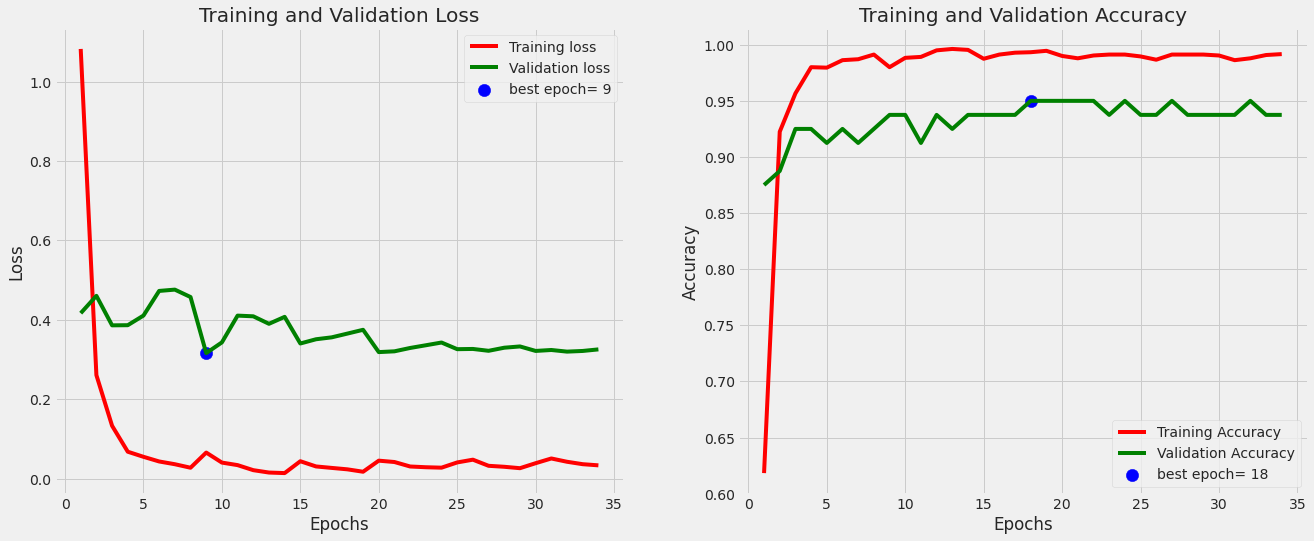

1/1 [==============================] - 1s 584ms/step - loss: 0.2371 - accuracy: 0.9250
accuracy on the test set is 92.50 %

model was saved as ./MyDrive/MyDrive/archive/EfficientNetB4_Damage_prediction_model_withAttemtion.hdf5-instruments-92.50.h5

class csv file was saved as ./MyDrive/MyDrive/archive/class_dict.csv



In [ ]:
tr_plot(history_eff4_atten,0)
subject='instruments'
acc=model_atten_b4.evaluate( test_gen, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
generator=train_gen
scale = 1
model_save_loc, csv_save_loc=saver(working_dir, model_atten_b3, model_name, subject, acc, img_size, scale,  generator)

          Filename                Predicted Class                True Class           Probability   

      image/1002.jpeg                head_lamp                  bumper_dent             0.5745

      image/1290.jpeg                 unknown                    head_lamp              0.5965

        image/5.jpeg                 door_dent                    unknown               0.9967

       image/146.jpeg                door_dent                  door_scratch            0.9483



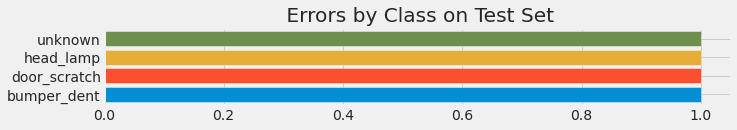

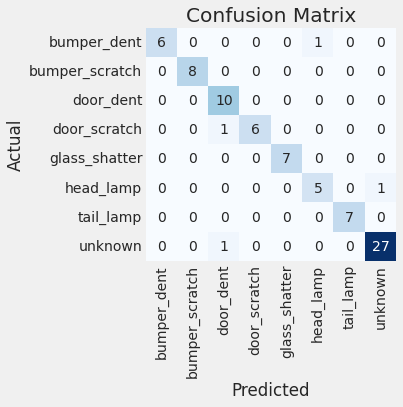

Classification Report:
----------------------
                 precision    recall  f1-score   support

   bumper_dent       1.00      0.86      0.92         7
bumper_scratch       1.00      1.00      1.00         8
     door_dent       0.83      1.00      0.91        10
  door_scratch       1.00      0.86      0.92         7
 glass_shatter       1.00      1.00      1.00         7
     head_lamp       0.83      0.83      0.83         6
     tail_lamp       1.00      1.00      1.00         7
       unknown       0.96      0.96      0.96        28

      accuracy                           0.95        80
     macro avg       0.95      0.94      0.94        80
  weighted avg       0.95      0.95      0.95        80

Over all F1 Score :  0.9500000000000001


In [ ]:
print_code=10 # set max value for number of mis-classified images files to print
preds=model_atten_b4.predict(test_gen) # make predictions on test set
print_info( test_gen, preds, print_code, working_dir, subject )  

# Attention Model on top of EfficientNetB3 LR @0.0001

In [ ]:
shape = 380
IMG_SIZE = 380

num_classes = 8
img_shape = (IMG_SIZE, IMG_SIZE, 3)
#inputs = Input(img_shape)
input_tensor = Input(shape=(shape, shape, 3))
# effB4_model=tf.keras.applications.EfficientNetB4(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 

base_model = tf.keras.applications.EfficientNetB3(input_tensor=input_tensor, weights='imagenet', include_top=False)
# effB4_model.trainable = True
effB3_outputs = base_model.output

# effB4_depth = effB4_model.layers[0].compute_output_shape(img_shape)[-1]
effB3_depth = 1
bn_outputs = BatchNormalization(name='BatchNormalization')(effB3_outputs)

# here we do an attention mechanism to turn pixels in the GAP on an off
atten_outputs = Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu')(bn_outputs)
atten_outputs = Conv2D(32, kernel_size = (3,3), padding = 'same', activation = 'relu')(atten_outputs)
atten_outputs = Conv2D(16, kernel_size = (3,3), padding = 'same', activation = 'relu')(atten_outputs)
atten_outputs = Conv2D(1, kernel_size = (1,1), padding = 'valid', activation = 'sigmoid')(atten_outputs)

# fan it out to all of the channels
weights = np.ones((1, 1, 1, effB3_depth))
outputs_up_c2 = Conv2D(effB3_depth, kernel_size = (1,1), padding = 'same', activation = 'linear', use_bias = False, weights = [weights])
outputs_up_c2.trainable = False
atten_outputs = outputs_up_c2(atten_outputs)

multiply_outputs = multiply([atten_outputs, bn_outputs], name='Multiply')
gap_features_ouputs = GlobalAveragePooling2D()(multiply_outputs)
gap_mask_ouputs = GlobalAveragePooling2D()(atten_outputs)

# to account for missing values from the attention model
outputs = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features_ouputs, gap_mask_ouputs])
outputs = Dropout(0.5)(outputs)
outputs = Dense(128, activation = 'elu')(outputs)
outputs = Dropout(0.25)(outputs)
outputs = Dense(num_classes, activation = 'softmax')(outputs)

# adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
losses = ['categorical_crossentropy']
# model.compile(adam, loss=losses, metrics=['accuracy'])
# checkpoint = ModelCheckpoint('damage_type_model.hdf5', save_best_only=True)
# LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience = 15)
model_atten_b3 = Model(inputs = [input_tensor], outputs = [outputs])
model_atten_b3.compile(Adamax(learning_rate=.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model_atten_b3.summary()

43950080/43941136 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 380, 380, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 380, 380, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 380, 380, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D

In [ ]:
epochs =40
patience= 5 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =5 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
ask_epoch=40 # number of epochs to run before asking if you want to halt training
batches=train_steps

model_name = 'EfficientNetB3_Damage_prediction_model_withAttemtion.hdf5'
model_path = os.path.join(working_dir,model_name)
checkpoint = ModelCheckpoint(model_path, save_best_only=True)

callbacks=[checkpoint, LRA(model=model_atten_b3,base_model= base_model ,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]

history_eff3_atten=model_atten_b3.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 initializing callback starting train with base_model trainable

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

 1 /40     1.874   30.464   1.28690  57.500   0.00010  0.00010  accuracy     0.00    392.85 

 2 /40     1.217   59.500   0.88384  78.750   0.00010  0.00010  accuracy    95.31    56.37  

 3 /40     0.851   71.821   0.73234  76.250   0.00010  0.00010  accuracy    20.71    56.92  

 4 /40     0.617   80.643   0.62983  76.250   0.00010  0.00010  accuracy    12.28    56.87  

 5 /40     0.474   84.929   0.55631  82.500   0.00010  0.00010  accuracy     5.31    56.42  

 6 /40     0.385   88.000   0.49721  82.500   0.00010  0.00010  accuracy     3.62    56.55  

 7 /40     0.304   90.821   0.47034  86.250   0.00010  0.00010  val_loss     5.40    56.50  

 8 /40     0.242   92.357   0.45173  85.000   0.00010  0.00010  val_loss     3.96    56.76  

 9 /40     0.202   93.107   0.42696  86.250   0.00010  0.00010  val_loss     5.48    56.51

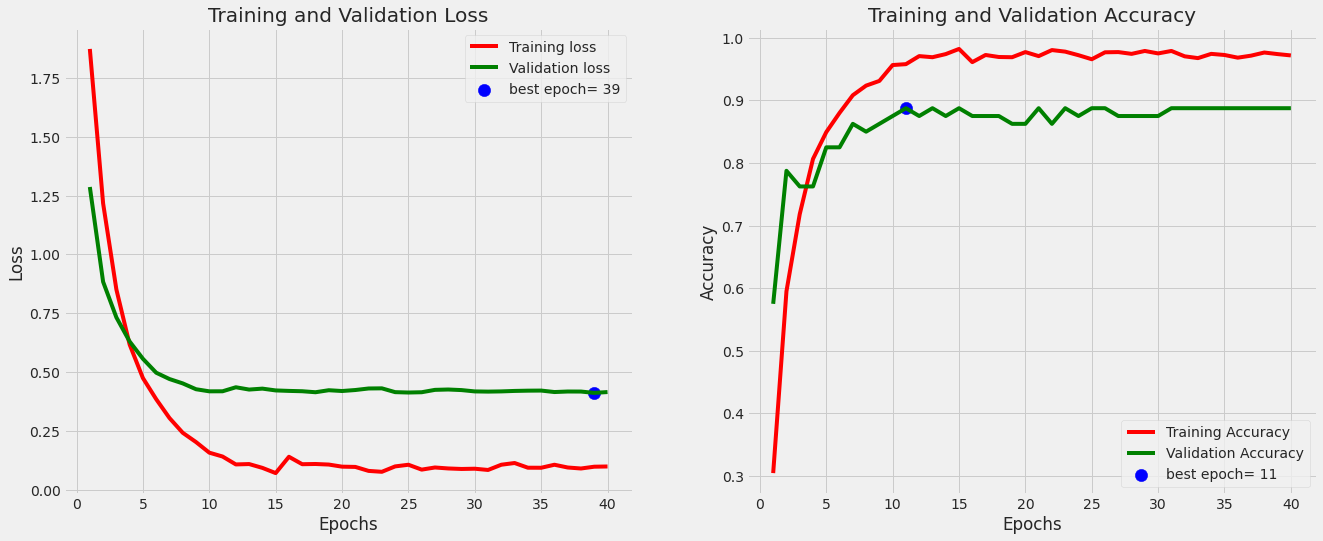

1/1 [==============================] - 2s 2s/step - loss: 0.1850 - accuracy: 0.9375
accuracy on the test set is 93.75 %

model was saved as ./MyDrive/MyDrive/archive/EfficientNetB3_Damage_prediction_model_withAttemtion.hdf5-instruments-93.75.h5

class csv file was saved as ./MyDrive/MyDrive/archive/class_dict.csv



In [ ]:
tr_plot(history_eff3_atten,0)
subject='instruments'
acc=model_atten_b3.evaluate( test_gen, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
generator=train_gen
scale = 1
model_save_loc, csv_save_loc=saver(working_dir, model_atten_b3, model_name, subject, acc, img_size, scale,  generator)

          Filename                Predicted Class                True Class           Probability   

      image/1002.jpeg                 unknown                   bumper_dent             0.6481

       image/169.jpeg                door_dent                  door_scratch            0.4510

      image/1092.jpeg                head_lamp                  bumper_dent             0.6107

      image/1290.jpeg                tail_lamp                   head_lamp              0.5547

       image/558.jpeg               door_scratch                 door_dent              0.3713



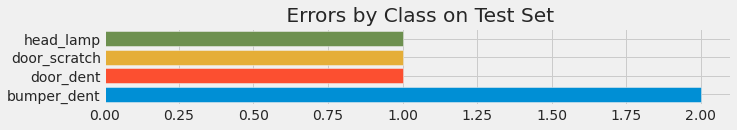

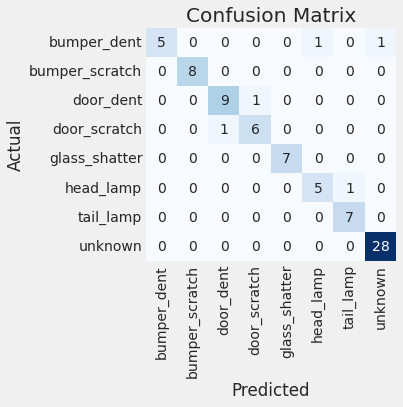

Classification Report:
----------------------
                 precision    recall  f1-score   support

   bumper_dent       1.00      0.71      0.83         7
bumper_scratch       1.00      1.00      1.00         8
     door_dent       0.90      0.90      0.90        10
  door_scratch       0.86      0.86      0.86         7
 glass_shatter       1.00      1.00      1.00         7
     head_lamp       0.83      0.83      0.83         6
     tail_lamp       0.88      1.00      0.93         7
       unknown       0.97      1.00      0.98        28

      accuracy                           0.94        80
     macro avg       0.93      0.91      0.92        80
  weighted avg       0.94      0.94      0.94        80



In [ ]:
print_code=10 # set max value for number of mis-classified images files to print
preds=model_atten_b3.predict(test_gen) # make predictions on test set
print_info( test_gen, preds, print_code, working_dir, subject )  

# Attention Model on top of EfficientNetB4

In [ ]:
shape = 380
IMG_SIZE = 380

num_classes = 8
img_shape = (IMG_SIZE, IMG_SIZE, 3)
#inputs = Input(img_shape)
input_tensor = Input(shape=(shape, shape, 3))
# effB4_model=tf.keras.applications.EfficientNetB4(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 

base_model = tf.keras.applications.EfficientNetB4(input_tensor=input_tensor, weights='imagenet', include_top=False)
# effB4_model.trainable = True
effB4_outputs = base_model.output

# effB4_depth = effB4_model.layers[0].compute_output_shape(img_shape)[-1]
effB4_depth = 1
bn_outputs = BatchNormalization(name='BatchNormalization')(effB4_outputs)

# here we do an attention mechanism to turn pixels in the GAP on an off
atten_outputs = Conv2D(64, kernel_size = (2,2), padding = 'same', activation = 'relu')(bn_outputs)
atten_outputs = Conv2D(32, kernel_size = (2,2), padding = 'same', activation = 'relu')(atten_outputs)
atten_outputs = Conv2D(16, kernel_size = (2,2), padding = 'same', activation = 'relu')(atten_outputs)
atten_outputs = Conv2D(1, kernel_size = (1,1), padding = 'valid', activation = 'sigmoid')(atten_outputs)

# fan it out to all of the channels
weights = np.ones((1, 1, 1, effB4_depth))
outputs_up_c2 = Conv2D(effB4_depth, kernel_size = (1,1), padding = 'same', activation = 'linear', use_bias = False, weights = [weights])
outputs_up_c2.trainable = False
atten_outputs = outputs_up_c2(atten_outputs)

multiply_outputs = multiply([atten_outputs, bn_outputs], name='Multiply')
gap_features_ouputs = GlobalAveragePooling2D()(multiply_outputs)
gap_mask_ouputs = GlobalAveragePooling2D()(atten_outputs)

# to account for missing values from the attention model
outputs = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features_ouputs, gap_mask_ouputs])
outputs = Dropout(0.5)(outputs)
outputs = Dense(128, activation = 'elu')(outputs)
outputs = Dropout(0.35)(outputs)
outputs = Dense(num_classes, activation = 'softmax')(outputs)

# adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
losses = ['categorical_crossentropy']
# model.compile(adam, loss=losses, metrics=['accuracy'])
# checkpoint = ModelCheckpoint('damage_type_model.hdf5', save_best_only=True)
# LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience = 15)
model_atten = Model(inputs = [input_tensor], outputs = [outputs])
model_atten.compile(Adamax(learning_rate=.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model_atten.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 380, 380, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 380, 380, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 380, 380, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                            

In [ ]:
epochs =40
patience= 5 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =5 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
ask_epoch=5 # number of epochs to run before asking if you want to halt training
batches=train_steps

model_name = 'EfficientNetB4_Damage_prediction_model_withAttemtion.hdf5'
model_path = os.path.join(working_dir,model_name)
checkpoint = ModelCheckpoint(model_path, save_best_only=True)

callbacks=[checkpoint, LRA(model=model_atten,base_model= base_model ,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]

history_eff4_atten=model_atten.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 initializing callback starting train with base_model trainable

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

 1 /40     1.921   28.000   1.31824  61.250   0.00010  0.00010  accuracy     0.00    96.09  

 2 /40     1.326   54.036   0.84156  75.000   0.00010  0.00010  accuracy    92.98    76.88  

 3 /40     0.932   68.107   0.65075  82.500   0.00010  0.00010  accuracy    26.04    72.71  

 4 /40     0.685   77.179   0.55128  82.500   0.00010  0.00010  accuracy    13.32    73.17  

 5 /40     0.516   83.143   0.46502  85.000   0.00010  0.00010  accuracy     7.73    73.43  

enter H to halt  or an integer for number of epochs to run then ask again

5
 training will continue until epoch 10

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

 6 /40     0.392   87.821   0.41544  88.750   0.00010  0.00010  accuracy     5.63    73.48  

 7 /40     0.295   90.750   0.37578  88.750   0.00010  0.00010  val_

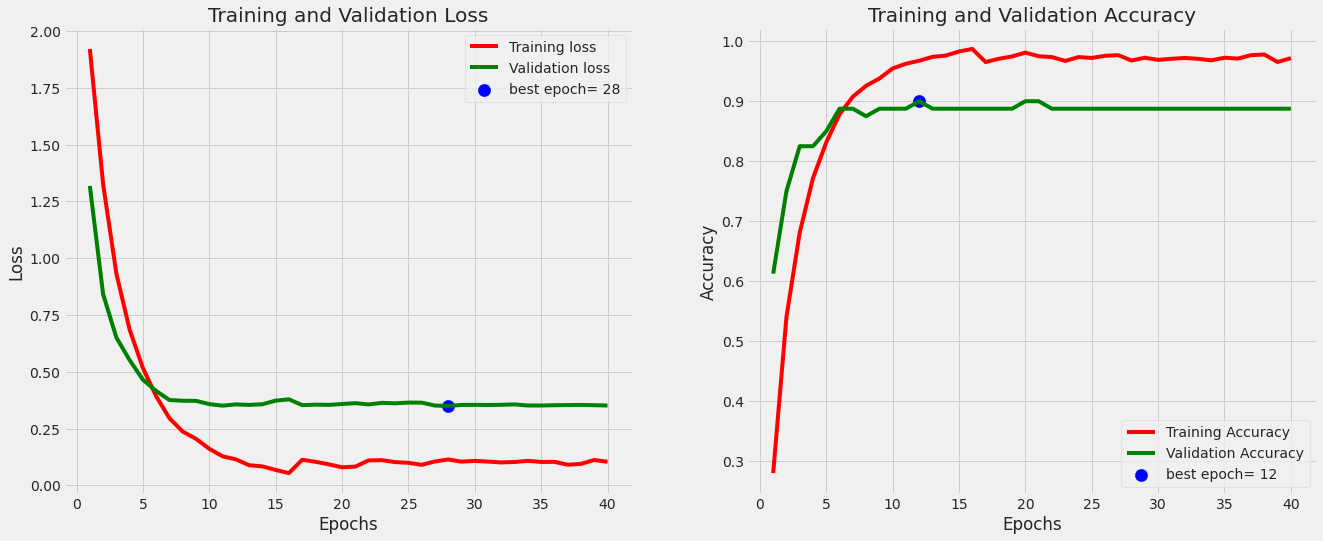

1/1 [==============================] - 1s 682ms/step - loss: 0.3736 - accuracy: 0.9000
accuracy on the test set is 90.00 %

model was saved as ./MyDrive/MyDrive/archive/EfficientNetB4_Damage_prediction_model_withAttemtion.hdf5-instruments-89.99.h5

class csv file was saved as ./MyDrive/MyDrive/archive/class_dict.csv



In [ ]:
tr_plot(history_eff4_atten,0)
subject='instruments'
acc=model_atten.evaluate( test_gen, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
generator=train_gen
scale = 1
model_save_loc, csv_save_loc=saver(working_dir, model_atten, model_name, subject, acc, img_size, scale,  generator)

          Filename                Predicted Class                True Class           Probability   

      image/1002.jpeg                head_lamp                  bumper_dent             0.9177

       image/659.jpeg              bumper_scratch                door_dent              0.2870

      image/1427.jpeg               bumper_dent                  tail_lamp              0.6764

       image/169.jpeg                door_dent                  door_scratch            0.4680

      image/1121.jpeg                tail_lamp                    unknown               0.9632

      image/1113.jpeg              glass_shatter                 tail_lamp              0.4634

      image/1466.jpeg              bumper_scratch                head_lamp              0.6632

       image/146.jpeg                 unknown                   door_scratch            0.5497



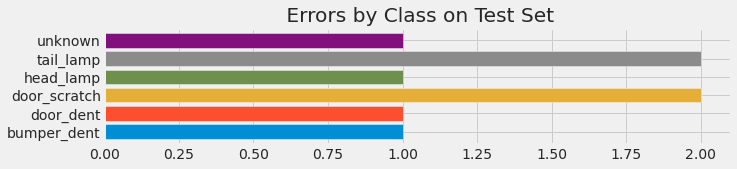

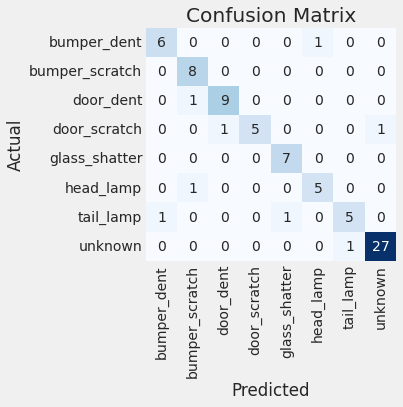

Classification Report:
----------------------
                 precision    recall  f1-score   support

   bumper_dent       0.86      0.86      0.86         7
bumper_scratch       0.80      1.00      0.89         8
     door_dent       0.90      0.90      0.90        10
  door_scratch       1.00      0.71      0.83         7
 glass_shatter       0.88      1.00      0.93         7
     head_lamp       0.83      0.83      0.83         6
     tail_lamp       0.83      0.71      0.77         7
       unknown       0.96      0.96      0.96        28

      accuracy                           0.90        80
     macro avg       0.88      0.87      0.87        80
  weighted avg       0.90      0.90      0.90        80



In [ ]:
print_code=10 # set max value for number of mis-classified images files to print
preds=model_atten.predict(test_gen) # make predictions on test set
print_info( test_gen, preds, print_code, working_dir, subject )  

# Plain EfficientNetB4 Model

In [ ]:
model_name='EfficientNetB4'
base_model=tf.keras.applications.EfficientNetB4(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
new_input = base_model.input
hidden_layer = base_model.layers[-1].output

image_features_extract_efficient_model = keras.Model(new_input,hidden_layer)
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(128, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006), bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.5, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)
model_b4=Model(inputs=base_model.input, outputs=output)
model_b4.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy']) 
model_b4.summary()

71696384/71686520 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding

In [ ]:
epochs =40
patience= 5 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =5 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
ask_epoch=None # number of epochs to run before asking if you want to halt training
batches=train_steps

model_name = 'EfficientNetB4_Damage_prediction_model.hdf5'
model_path = os.path.join(working_dir,model_name)
checkpoint = ModelCheckpoint(model_path, save_best_only=True)

callbacks=[checkpoint, LRA(model=model_b4,base_model= base_model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]

history_eff4=model_b4.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 initializing callback starting train with base_model trainable

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

 1 /40     5.585   53.500   4.67814  81.250   0.00100  0.00100  accuracy     0.00    176.88 

 2 /40     4.166   84.167   4.04012  85.000   0.00100  0.00100  accuracy    57.32    64.73  

 3 /40     3.551   92.292   3.50986  88.750   0.00100  0.00100  val_loss    13.12    63.31  

 4 /40     3.093   95.958   3.12095  91.250   0.00100  0.00100  val_loss    11.08    63.85  

 5 /40     2.704   97.583   2.74839  90.000   0.00100  0.00100  val_loss    11.94    63.50  

 6 /40     2.357   98.542   2.43954  88.750   0.00100  0.00100  val_loss    11.24    63.86  

 7 /40     2.057   98.875   2.13299  91.250   0.00100  0.00100  val_loss    12.57    65.26  

 8 /40     1.793   99.083   1.89568  92.500   0.00100  0.00100  val_loss    11.13    63.96  

 9 /40     1.556   99.208   1.66763  93.750   0.00100  0.00100  val_loss    12.03    63.59

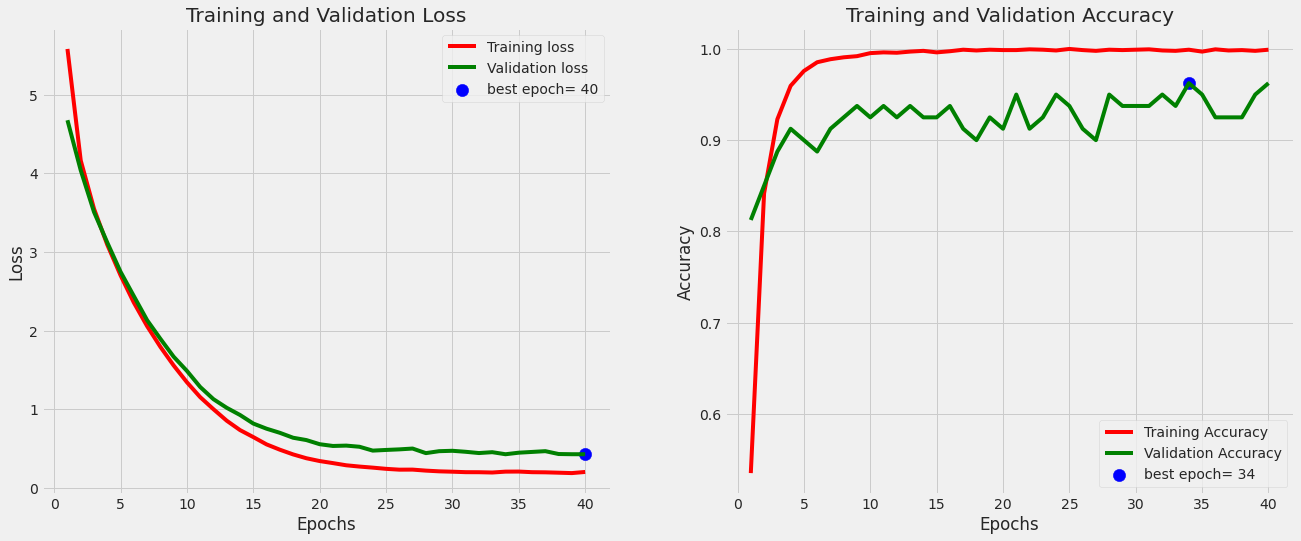

1/1 [==============================] - 2s 2s/step - loss: 0.3817 - accuracy: 0.9375
accuracy on the test set is 93.75 %

model was saved as ./MyDrive/MyDrive/archive/EfficientNetB4_Damage_prediction_model.hdf5-instruments-93.75.h5

class csv file was saved as ./MyDrive/MyDrive/archive/class_dict.csv



In [ ]:
tr_plot(history_eff4,0)
subject='instruments'
acc=model_b4.evaluate( test_gen, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
generator=train_gen
scale = 1
model_save_loc, csv_save_loc=saver(working_dir, model_b4, model_name, subject, acc, img_size, scale,  generator)

          Filename                Predicted Class                True Class           Probability   

      image/1002.jpeg                head_lamp                  bumper_dent             0.9432

       image/269.jpeg                head_lamp                    unknown               0.7578

       image/289.jpeg                door_dent                  door_scratch            0.8534

       image/183.jpeg                 unknown                   bumper_dent             0.7775

        image/5.jpeg                 door_dent                    unknown               0.5698



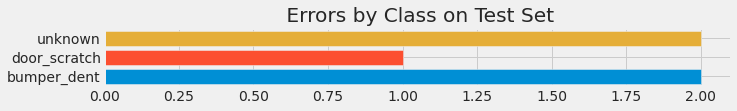

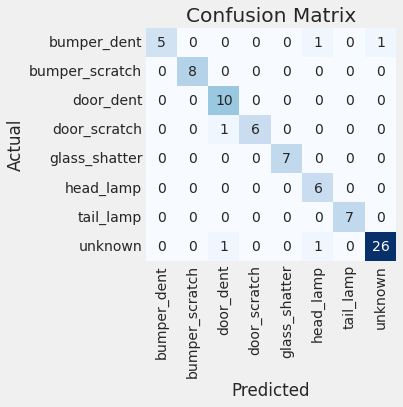

Classification Report:
----------------------
                 precision    recall  f1-score   support

   bumper_dent       1.00      0.71      0.83         7
bumper_scratch       1.00      1.00      1.00         8
     door_dent       0.83      1.00      0.91        10
  door_scratch       1.00      0.86      0.92         7
 glass_shatter       1.00      1.00      1.00         7
     head_lamp       0.75      1.00      0.86         6
     tail_lamp       1.00      1.00      1.00         7
       unknown       0.96      0.93      0.95        28

      accuracy                           0.94        80
     macro avg       0.94      0.94      0.93        80
  weighted avg       0.95      0.94      0.94        80



In [ ]:
print_code=10 # set max value for number of mis-classified images files to print
preds=model_b4.predict(test_gen) # make predictions on test set
print_info( test_gen, preds, print_code, working_dir, subject )  

# EfficientNetB4 Model with Attention Mechanism

In [ ]:
shape = 380
IMG_SIZE = 380

num_classes = 8
img_shape = (IMG_SIZE, IMG_SIZE, 3)
#inputs = Input(img_shape)
input_tensor = Input(shape=(shape, shape, 3))
# effB4_model=tf.keras.applications.EfficientNetB4(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 

base_model = tf.keras.applications.EfficientNetB4(input_tensor=input_tensor, weights='imagenet', include_top=False)
#effB4_model.trainable = False
effB4_outputs = base_model.output

# effB4_depth = base_model.layers[0].compute_output_shape(img_shape)[0]
effB4_depth = 1792
bn_outputs = BatchNormalization(name='BatchNormalization')(effB4_outputs)

# here we do an attention mechanism to turn pixels in the GAP on an off
atten_outputs = Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu')(bn_outputs)
# atten_outputs = Conv2D(64, kernel_size = (2,2), padding = 'same', activation = 'relu')(atten_outputs)
atten_outputs = Conv2D(32, kernel_size = (2,2), padding = 'same', activation = 'relu')(atten_outputs)
atten_outputs = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(atten_outputs)
atten_outputs = Conv2D(1, kernel_size = (1,1), padding = 'valid', activation = 'sigmoid')(atten_outputs)

# fan it out to all of the channels
weights = np.ones((1, 1, 1, effB4_depth))
outputs_up_c2 = Conv2D(effB4_depth, kernel_size = (1,1), padding = 'same', activation = 'linear', use_bias = False, weights = [weights])
outputs_up_c2.trainable = False
atten_outputs = outputs_up_c2(atten_outputs)

multiply_outputs = multiply([atten_outputs, bn_outputs], name='Multiply')
gap_features_ouputs = GlobalAveragePooling2D()(multiply_outputs)
gap_mask_ouputs = GlobalAveragePooling2D()(atten_outputs)

# to account for missing values from the attention model
outputs = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features_ouputs, gap_mask_ouputs])
outputs = Dropout(0.5)(outputs)
outputs = Dense(128, activation = 'relu')(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(num_classes, activation = 'softmax')(outputs)

# adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
losses = ['categorical_crossentropy']
# model.compile(adam, loss=losses, metrics=['accuracy'])
# checkpoint = ModelCheckpoint('damage_type_model.hdf5', save_best_only=True)
# LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience = 15)
model_atten = Model(inputs = [input_tensor], outputs = [outputs])
model_atten.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy'])
model_atten.summary()

71696384/71686520 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 380, 380, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 380, 380, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 380, 380, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D

In [ ]:
base_model.layers[0].compute_output_shape(img_shape)[0]

380

In [ ]:
epochs =40
patience= 5 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =5 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
ask_epoch=None # number of epochs to run before asking if you want to halt training
batches=train_steps

model_name = 'EfficientNetB4_Damage_prediction_model_withAttemtion.hdf5'
model_path = os.path.join(working_dir,model_name)
checkpoint = ModelCheckpoint(model_path, save_best_only=True)

callbacks=[checkpoint, LRA(model=model_atten,base_model= base_model ,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]

history_eff4_atten=model_atten.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 initializing callback starting train with base_model trainable

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

 1 /40     1.239   56.292   0.39702  88.750   0.00100  0.00100  accuracy     0.00    153.59 

 2 /40     0.347   89.583   0.34397  88.750   0.00100  0.00100  accuracy    59.14    44.81  

 3 /40     0.145   95.292   0.37474  92.500   0.00100  0.00100  val_loss    -8.95    40.19  

 4 /40     0.118   96.458   0.39146  90.000   0.00100  0.00100  val_loss    -13.81   40.02  

 5 /40     0.070   98.042   0.44837  92.500   0.00100  0.00100  val_loss    -30.35   39.99  

 6 /40     0.061   98.292   0.43310  88.750   0.00100  0.00100  val_loss    -25.91   39.99  

 7 /40     0.051   98.458   0.46990  92.500   0.00100  0.00050  val_loss    -36.61   39.89  

 8 /40     0.144   96.083   0.28714  92.500   0.00050  0.00050  val_loss    16.52    44.67  

 9 /40     0.120   96.458   0.28793  93.750   0.00050  0.00050  val_loss    -0.27    39.78

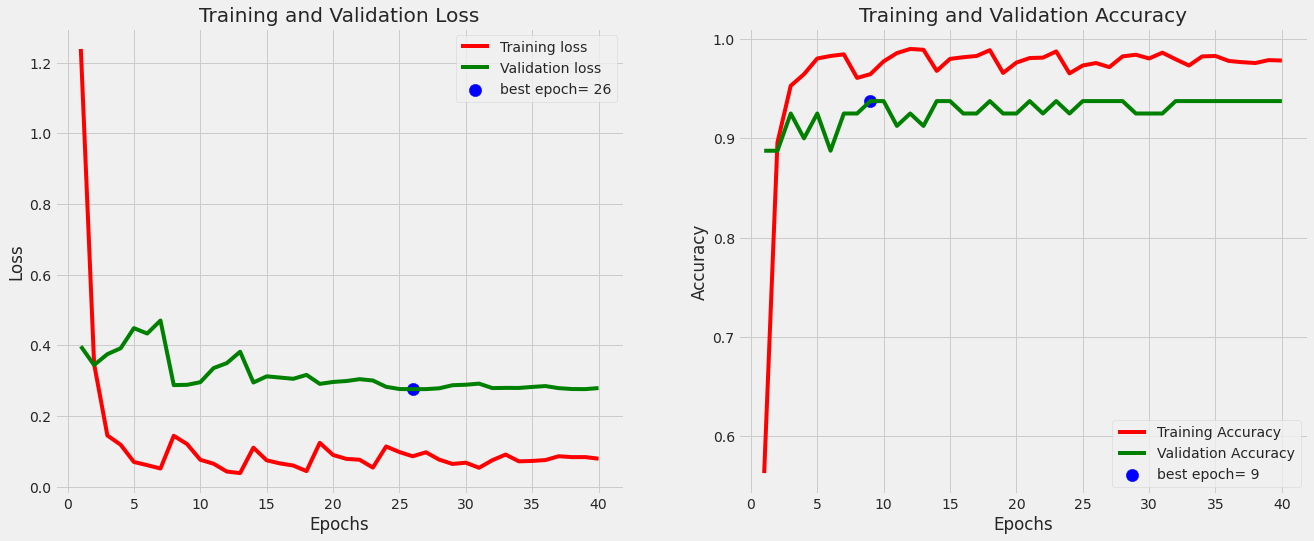

1/1 [==============================] - 1s 892ms/step - loss: 0.1486 - accuracy: 0.9750
accuracy on the test set is 97.50 %

model was saved as ./MyDrive/MyDrive/archive/EfficientNetB4_Damage_prediction_model_withAttemtion.hdf5-instruments-97.50.h5

class csv file was saved as ./MyDrive/MyDrive/archive/class_dict.csv



In [ ]:
tr_plot(history_eff4_atten,0)
subject='instruments'
acc=model_atten.evaluate( test_gen, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
generator=train_gen
scale = 1
model_save_loc, csv_save_loc=saver(working_dir, model_atten, model_name, subject, acc, img_size, scale,  generator)

          Filename                Predicted Class                True Class           Probability   

      image/1002.jpeg               door_scratch                bumper_dent             0.3449

      image/1466.jpeg              bumper_scratch                head_lamp              0.6158



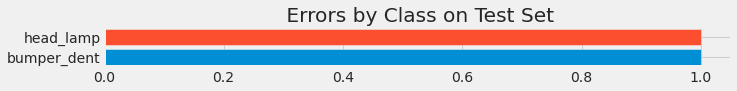

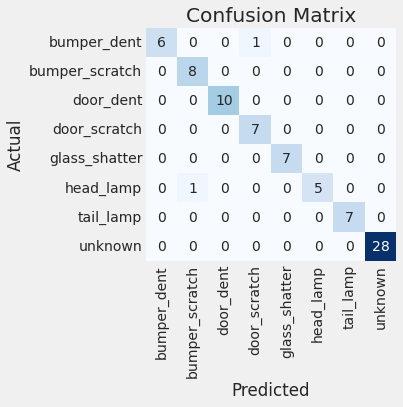

Classification Report:
----------------------
                 precision    recall  f1-score   support

   bumper_dent       1.00      0.86      0.92         7
bumper_scratch       0.89      1.00      0.94         8
     door_dent       1.00      1.00      1.00        10
  door_scratch       0.88      1.00      0.93         7
 glass_shatter       1.00      1.00      1.00         7
     head_lamp       1.00      0.83      0.91         6
     tail_lamp       1.00      1.00      1.00         7
       unknown       1.00      1.00      1.00        28

      accuracy                           0.97        80
     macro avg       0.97      0.96      0.96        80
  weighted avg       0.98      0.97      0.97        80



In [ ]:
print_code=10 # set max value for number of mis-classified images files to print
preds=model_atten.predict(test_gen) # make predictions on test set
print_info( test_gen, preds, print_code, working_dir, subject )  

# EfficientNetB4 Model with Another Attention implementation

In [ ]:
shape = 380
IMG_SIZE = 380

num_classes = 8
img_shape = (IMG_SIZE, IMG_SIZE, 3)
#inputs = Input(img_shape)
input_tensor = Input(shape=(shape, shape, 3))
# effB4_model=tf.keras.applications.EfficientNetB4(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 

base_model = tf.keras.applications.EfficientNetB4(input_tensor=input_tensor, weights='imagenet', include_top=False)
# effB4_model.trainable = True
effB3_outputs = base_model.output

# effB4_depth = base_model.layers[0].compute_output_shape(img_shape)[0]
effB3_depth = 1792
bn_outputs = BatchNormalization(name='BatchNormalization')(effB3_outputs)

# here we do an attention mechanism to turn pixels in the GAP on an off
atten_outputs = Conv2D(128, kernel_size = (3,3), padding = 'same', activation = 'relu')(bn_outputs)
atten_outputs = Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu')(atten_outputs)
atten_outputs = Conv2D(32, kernel_size = (2,2), padding = 'same', activation = 'relu')(atten_outputs)
atten_outputs = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(atten_outputs)
atten_outputs = Conv2D(1, kernel_size = (1,1), padding = 'valid', activation = 'sigmoid')(atten_outputs)

# fan it out to all of the channels
weights = np.ones((1, 1, 1, effB3_depth))
outputs_up_c2 = Conv2D(effB3_depth, kernel_size = (1,1), padding = 'same', activation = 'linear', use_bias = False, weights = [weights])
outputs_up_c2.trainable = False
atten_outputs = outputs_up_c2(atten_outputs)

multiply_outputs = multiply([atten_outputs, bn_outputs], name='Multiply')
gap_features_ouputs = GlobalAveragePooling2D()(multiply_outputs)
gap_mask_ouputs = GlobalAveragePooling2D()(atten_outputs)

# to account for missing values from the attention model
outputs = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features_ouputs, gap_mask_ouputs])
outputs = Dropout(0.5)(outputs)
outputs = Dense(128, activation = 'relu')(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(num_classes, activation = 'softmax')(outputs)

# adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
losses = ['categorical_crossentropy']
# model.compile(adam, loss=losses, metrics=['accuracy'])
# checkpoint = ModelCheckpoint('damage_type_model.hdf5', save_best_only=True)
# LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience = 15)
model_atten = Model(inputs = [input_tensor], outputs = [outputs])
model_atten.compile(Adamax(learning_rate=.005), loss='categorical_crossentropy', metrics=['accuracy'])
model_atten.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 380, 380, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_5 (Rescaling)        (None, 380, 380, 3)  0           ['input_6[0][0]']                
                                                                                                  
 normalization_5 (Normalization  (None, 380, 380, 3)  7          ['rescaling_5[0][0]']            
 )                                                                                                
                                                                                            

In [ ]:
epochs =40
patience= 10 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =10 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
ask_epoch=None # number of epochs to run before asking if you want to halt training
batches=train_steps

model_name = 'EfficientNetB3_Damage_prediction_model_withAttemtion.hdf5'
model_path = os.path.join(working_dir,model_name)
checkpoint = ModelCheckpoint(model_path, save_best_only=True)

callbacks=[checkpoint, LRA(model=model_atten,base_model= base_model ,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]

history_eff4_atten=model_atten.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 initializing callback starting train with base_model trainable

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

 1 /40     1.363   54.250   4.31885  33.750   0.00500  0.00500  accuracy     0.00    73.87  

 2 /40     0.751   76.000   0.80084  75.000   0.00500  0.00500  accuracy    40.09    46.84  

 3 /40     0.469   86.042   1.16210  68.750   0.00500  0.00500  accuracy    13.21    40.71  

 4 /40     0.364   89.083   0.51773  81.250   0.00500  0.00500  accuracy     3.54    46.66  

 5 /40     0.341   90.333   0.74779  80.000   0.00500  0.00500  val_loss    -44.43   40.97  

 6 /40     0.237   92.500   0.70056  81.250   0.00500  0.00500  val_loss    -35.31   40.61  

 7 /40     0.241   92.417   1.10404  76.250   0.00500  0.00500  val_loss   -113.25   40.66  

 8 /40     0.182   94.500   0.57007  83.750   0.00500  0.00500  val_loss    -10.11   40.56  

 9 /40     0.170   94.792   0.76725  83.750   0.00500  0.00500  val_loss    -48.19   40.73

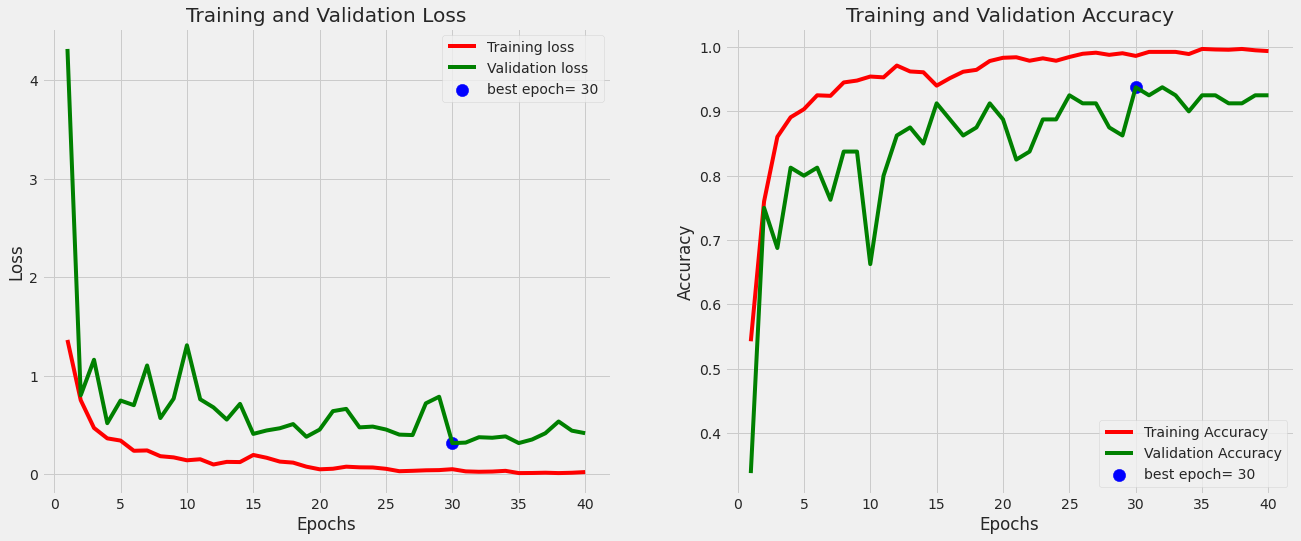

1/1 [==============================] - 1s 523ms/step - loss: 0.5064 - accuracy: 0.8750
accuracy on the test set is 87.50 %

model was saved as ./MyDrive/MyDrive/archive/EfficientNetB3_Damage_prediction_model_withAttemtion.hdf5-instruments-87.5.h5

class csv file was saved as ./MyDrive/MyDrive/archive/class_dict.csv



In [ ]:
tr_plot(history_eff4_atten,0)
subject='instruments'
acc=model_atten.evaluate( test_gen, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
generator=train_gen
scale = 1
model_save_loc, csv_save_loc=saver(working_dir, model_atten, model_name, subject, acc, img_size, scale,  generator)

          Filename                Predicted Class                True Class           Probability   

      image/1002.jpeg                head_lamp                  bumper_dent             0.4736

       image/289.jpeg                door_dent                  door_scratch            0.8255

       image/169.jpeg                door_dent                  door_scratch            0.5390

       image/608.jpeg                door_dent                  door_scratch            0.6389

      image/1121.jpeg              glass_shatter                  unknown               0.6312

      image/1290.jpeg                 unknown                    head_lamp              0.7118

      image/1466.jpeg              bumper_scratch                head_lamp              0.5241



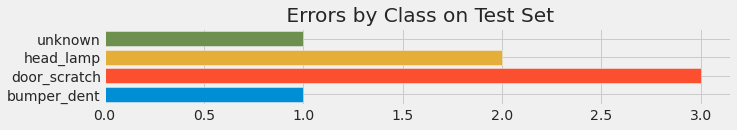

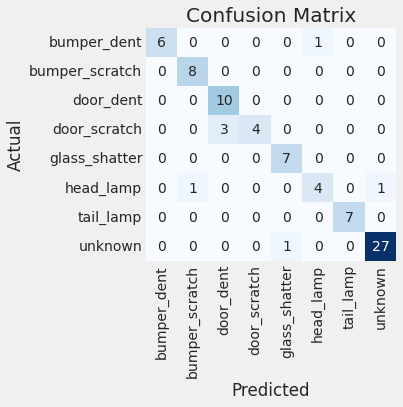

Classification Report:
----------------------
                 precision    recall  f1-score   support

   bumper_dent       1.00      0.86      0.92         7
bumper_scratch       0.89      1.00      0.94         8
     door_dent       0.77      1.00      0.87        10
  door_scratch       1.00      0.57      0.73         7
 glass_shatter       0.88      1.00      0.93         7
     head_lamp       0.80      0.67      0.73         6
     tail_lamp       1.00      1.00      1.00         7
       unknown       0.96      0.96      0.96        28

      accuracy                           0.91        80
     macro avg       0.91      0.88      0.89        80
  weighted avg       0.92      0.91      0.91        80

Over all F1 Score :  0.9125


In [ ]:
print_code=10 # set max value for number of mis-classified images files to print
preds=model_atten.predict(test_gen) # make predictions on test set
print_info( test_gen, preds, print_code, working_dir, subject )  